# Retrieval results

This notebook contains the analysis of the retrieval results of the LIRAS joint
active and passive retrievals for the first test scene.

In [7]:
%env LIRAS_PATH=/old/projects/LIRAS/Development/liras
%load_ext autoreload
%autoreload 2
from mcrf.utils.setup_notebook import *
from netCDF4 import Dataset
from mcrf.liras import liras_path
from mcrf.liras.model_data import ModelDataProvider
from mcrf.liras.results import get_results, get_reference_data

env: LIRAS_PATH=/old/projects/LIRAS/Development/liras
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load results

In [8]:
variables = ["diagnostics", "rain_dm", "rain_n0", "ice_dm", "ice_n0", "snow_dm", "snow_n0", "H2O", "y_ici", "y_mwi", "yf_ici", "yf_mwi", "y_lcpr", "yf_lcpr", "cloud_water"]
results   = get_results(variables = variables, scene = "b", config = "", type_suffix = "")
results_r = get_results(variables = variables, scene = "b", config = "reference", type_suffix = "")
results_ro = get_results(variables = variables, scene = "b", config = "", type_suffix = "ro")
results_po = get_results(variables = variables, scene = "b", config = "", type_suffix = "po")

In [9]:
_ = results.pop("GemGraupel_None")

In [10]:
results.keys()

dict_keys(['GemCloudIce_None', 'IceSphere_None', '8-ColumnAggregate_LargePlateAggregate', 'LargePlateAggregate_None', 'LargeColumnAggregate_None', 'PlateType1_None', 'SectorSnowflake_None', '8-ColumnAggregate_None', 'GemSnow_None', 'GemCloudIce_GemSnow'])

## Reference values

In [11]:
reference = get_reference_data(scene = "b", i_start = 2200, i_end = 3000)

/home/simonpf/src/parts/parts/scattering/psd/my05.py:208: RuntimeWarning: invalid value encountered in true_divide
  / gamma((nu + 1) / mu)
/home/simonpf/src/parts/parts/scattering/psd/my05.py:280: RuntimeWarning: divide by zero encountered in power
  m = n0 / mu * lmbd ** (-(nu + p + 1) / mu) * gamma((nu + 1.0 + p) / mu)
/home/simonpf/src/parts/parts/scattering/psd/my05.py:280: RuntimeWarning: invalid value encountered in multiply
  m = n0 / mu * lmbd ** (-(nu + p + 1) / mu) * gamma((nu + 1.0 + p) / mu)
/home/simonpf/src/parts/parts/scattering/psd/d14.py:412: RuntimeWarning: invalid value encountered in true_divide
  dm = m4 / m3
/home/simonpf/src/parts/parts/scattering/psd/d14.py:414: RuntimeWarning: invalid value encountered in true_divide
  n0 = 4.0 ** 4 / (np.pi * self.rho) * md / dm ** 4
/home/simonpf/src/parts/parts/scattering/psd/my05.py:208: RuntimeWarning: divide by zero encountered in true_divide
  / gamma((nu + 1) / mu)


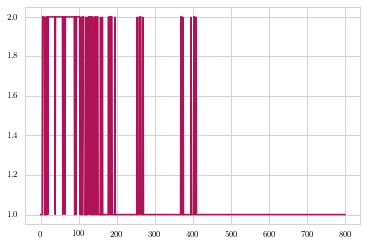

In [12]:
diag = results["8-ColumnAggregate_None"]["diagnostics"]
plt.plot(diag[:, 0])

## Results

### Mass density

In [13]:
from mcrf.liras.results import plot_results
def iwc(n0, dm):
    return np.pi * 917.0 * dm ** 4 * n0 / 4 ** 4

GemCloudIce_None
IceSphere_None
LargePlateAggregate_None
LargeColumnAggregate_None
PlateType1_None
SectorSnowflake_None
8-ColumnAggregate_None
GemSnow_None


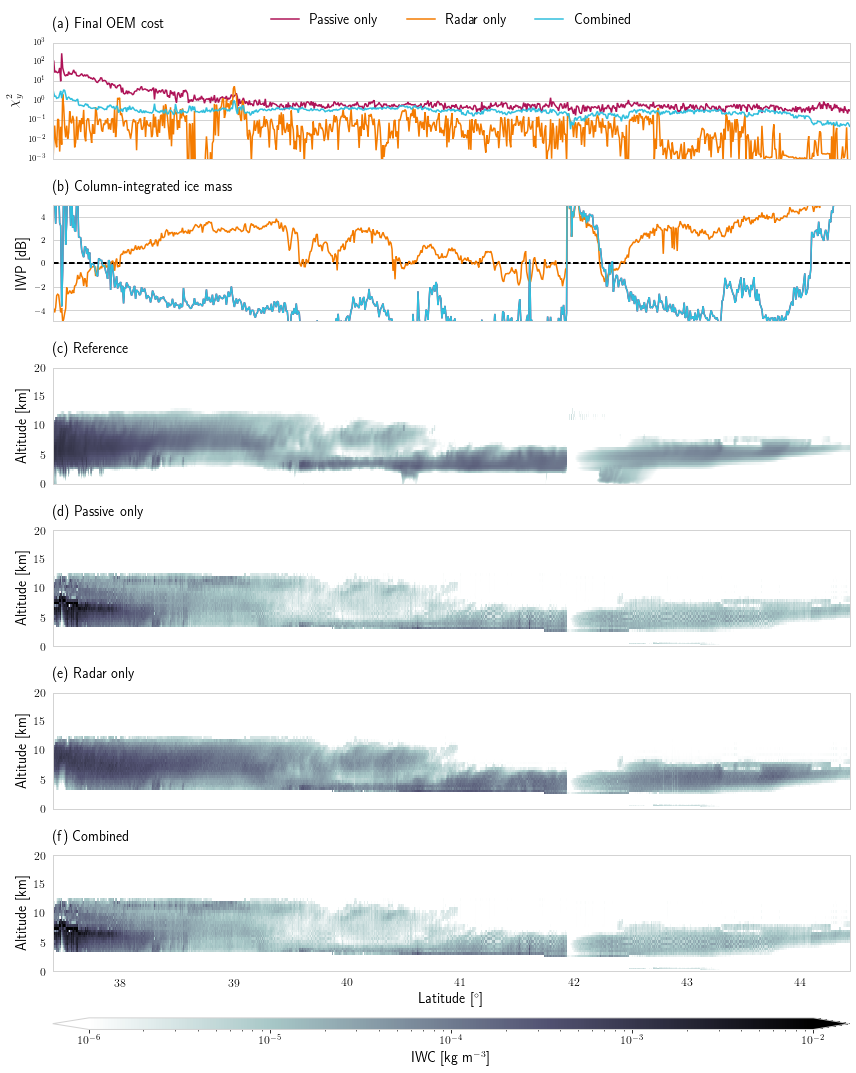

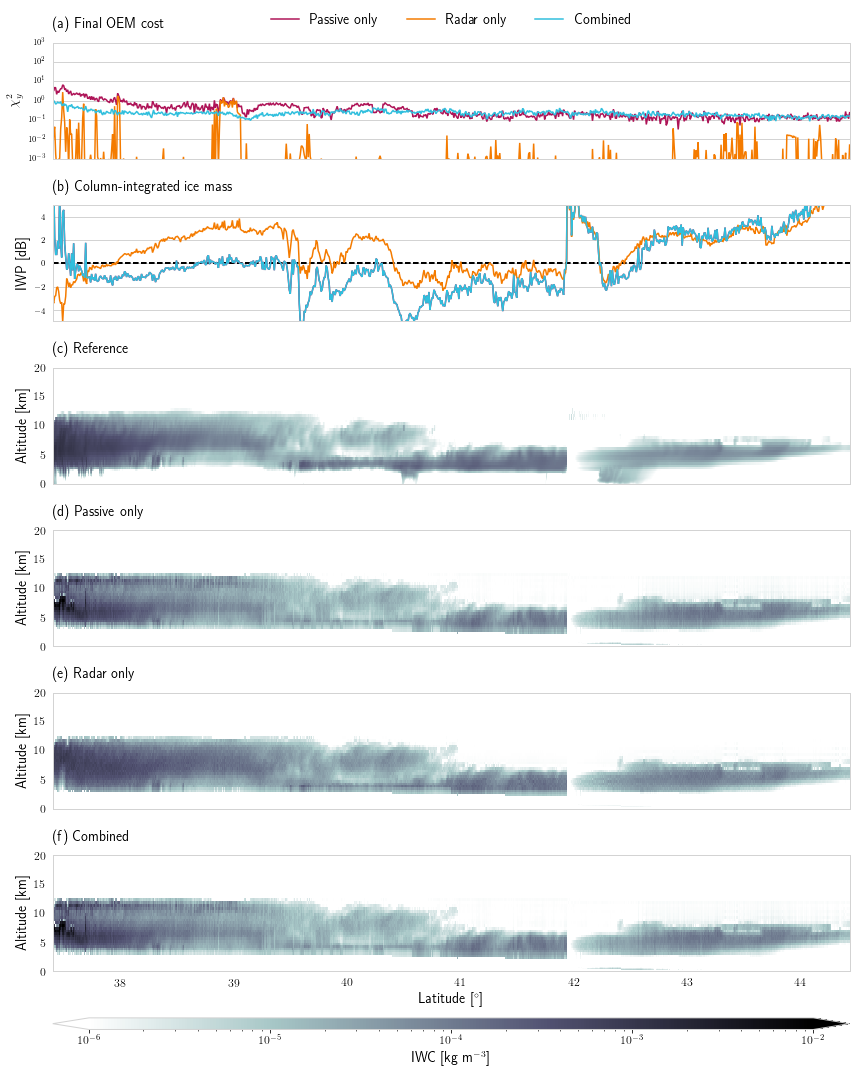

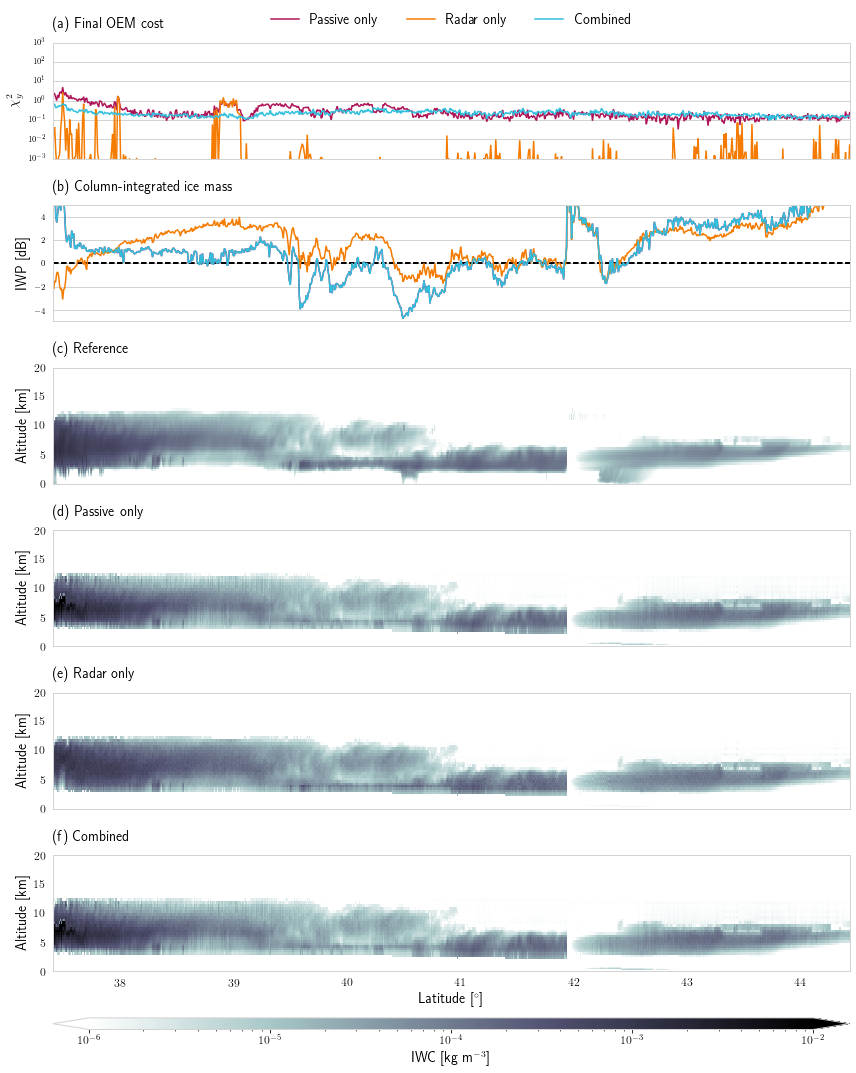

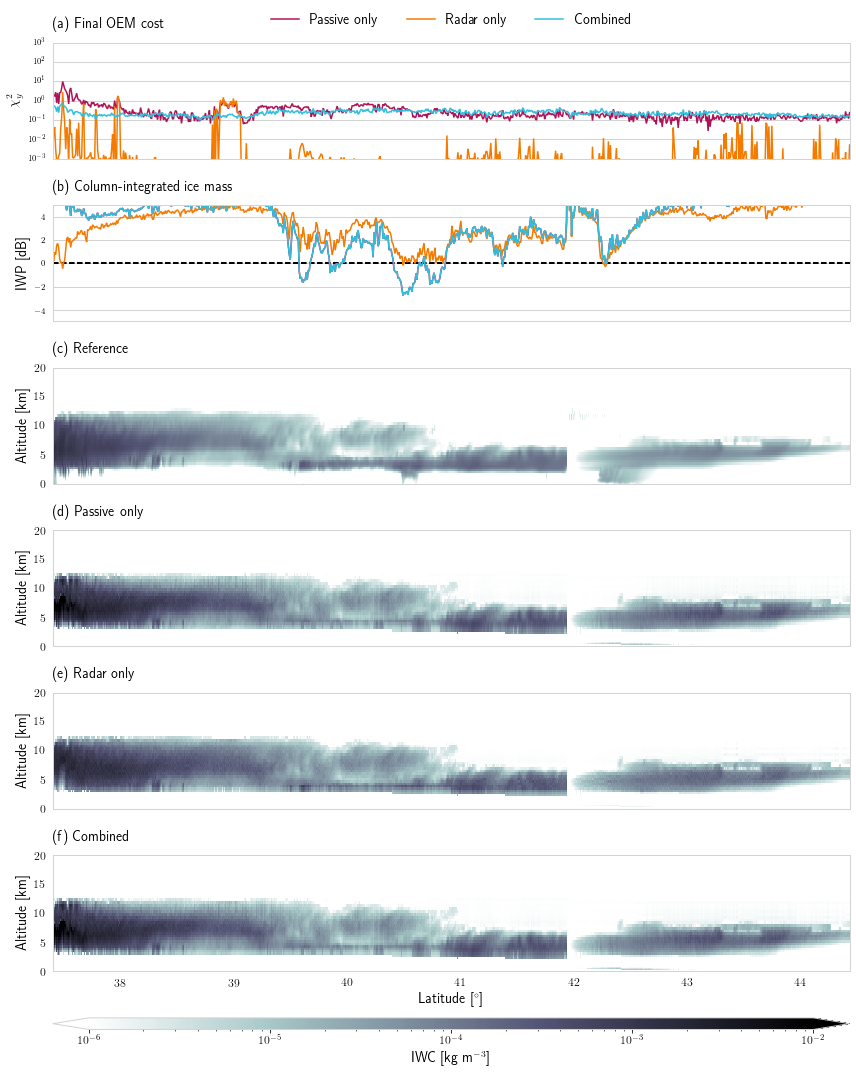

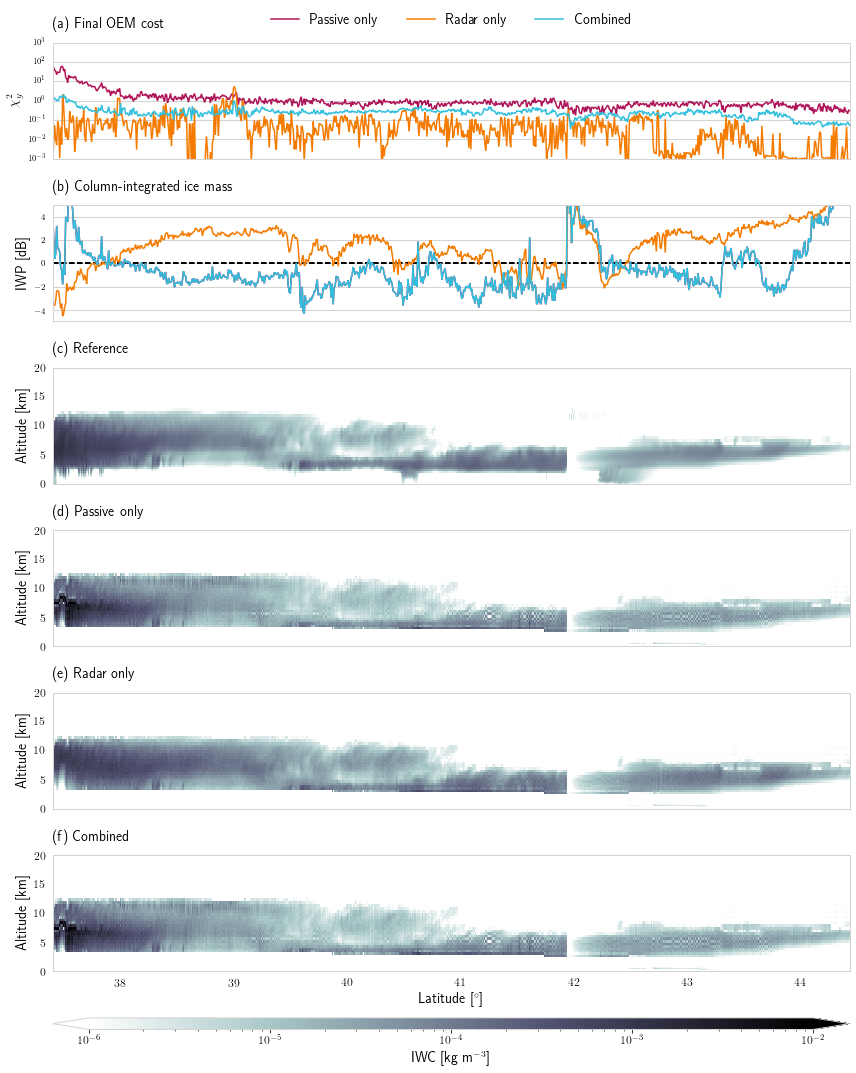

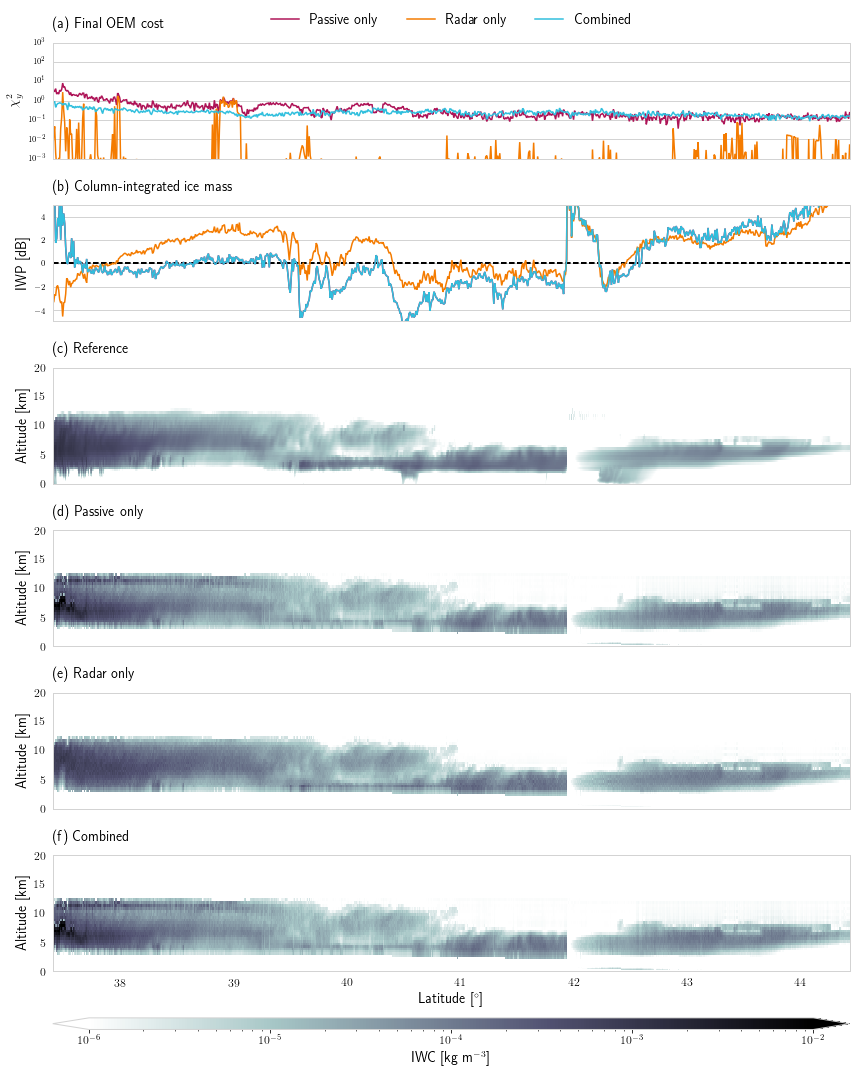

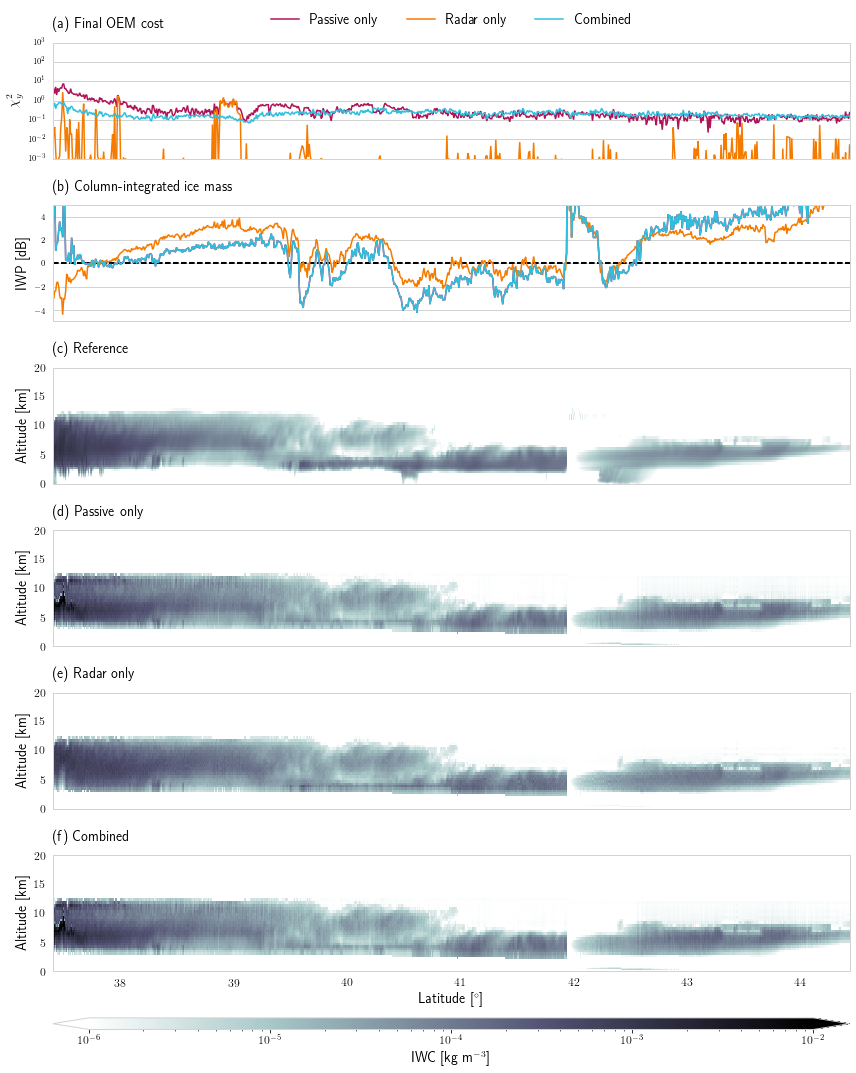

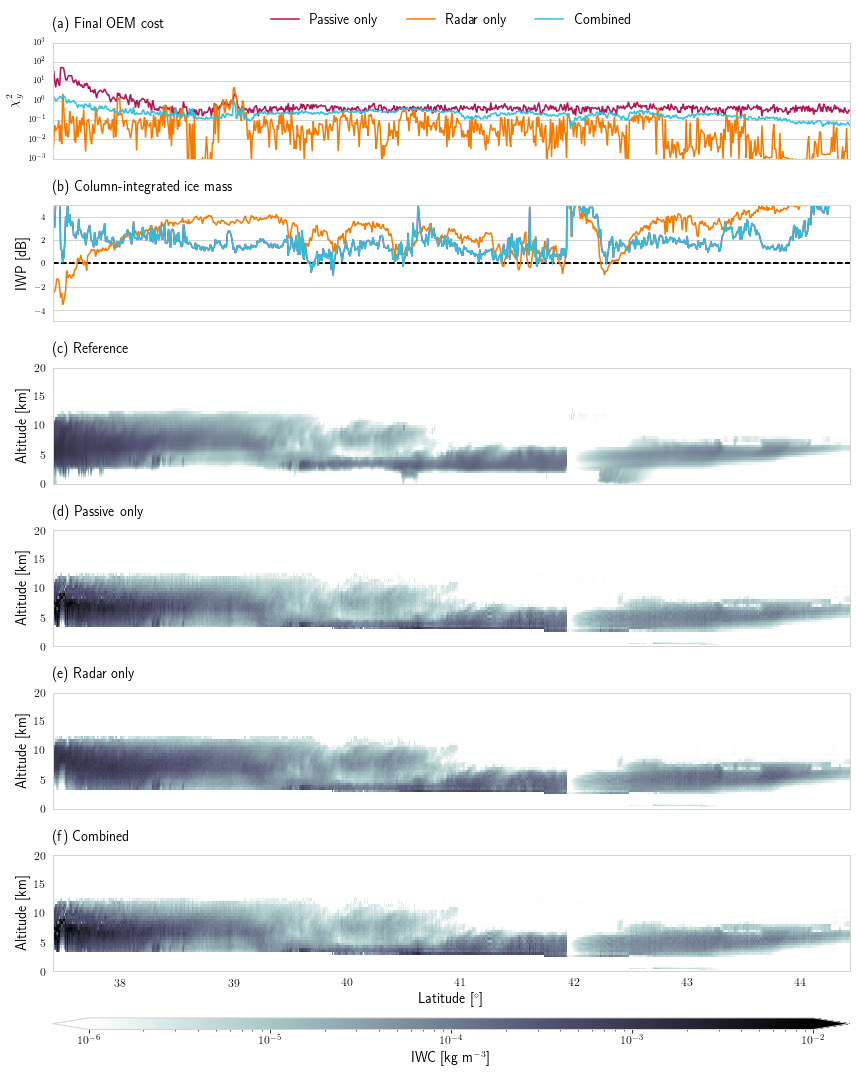

In [14]:
from matplotlib.colors import LogNorm
from matplotlib.cm import bone_r
lats = reference["lat"]
z    = reference["z"]
name = "IWC [kg m$^{-3}$]"
norm = LogNorm(1e-6, 1e-2)
cmap = bone_r
titles = ["Reference", "Passive only", "Radar only", "Combined"]

for h in [h for h in results.keys() if "_None" in h]:
    rs    = results[h]
    rs_po = results[h]
    rs_ro = results_ro[h]
    print(h)
    
    costs = []
    costs += [rs_po["diagnostics"][:, 3]]
    costs += [rs_ro["diagnostics"][:, 3]]
    costs += [rs["diagnostics"][:, 2] - rs["diagnostics"][:, 3]]
    
    qs = []
    
    qs += [np.maximum(reference["iwc"] + reference["swc"] + reference["hwc"] + reference["gwc"], 1e-10)]
    
    qs += [iwc(rs_po["ice_n0"], rs_po["ice_dm"])]
    if not rs_po["snow_n0"] is None:
        qs[-1] += iwc(rs_po["snow_n0"], rs_po["snow_dm"])
        
    qs += [iwc(rs_ro["ice_n0"], rs_ro["ice_dm"])]
    if not rs_ro["snow_n0"] is None:
        qs[-1] += iwc(rs_ro["snow_n0"], rs_ro["snow_dm"])
    
    qs += [iwc(rs["ice_n0"], rs["ice_dm"])]
    if not rs["snow_n0"] is None:
        qs[-1] += iwc(rs["snow_n0"], rs["snow_dm"])
        
    
    f = plt.figure(figsize = (12, 15))
    plot_results(lats, z, qs, name, norm, costs, cmap,
                 include_columns = True,
                 column_label = "IWP [dB]",
                 titles = titles)
    
    ax = f.axes[1]
    ax.axhline(0.0, ls = "--", c = "k", zorder = 1, lw = 2)
    ax.set_title("(b) Column-integrated ice mass", loc = "left", fontsize = 14)
    if "None" in h:
        f.savefig("../../../plots/results_b_" + h[:-5] + ".png", bbox_inches = "tight", dpi = 300)
    else:
        f.savefig("../../../plots/results_b_" + h + ".png", bbox_inches = "tight", dpi = 300)

## Retrieval performance

In [34]:
qs = {}
qs_ro = {}
qs_po = {}

xx  = np.broadcast_to(lats.reshape(-1, 1), reference["iwc"].shape)
q_r = np.maximum(reference["iwc"] + reference["swc"] + reference["hwc"] + reference["gwc"], 1e-8)

for h in results.keys():
    rs = results[h]
    q    = iwc(rs["ice_n0"], rs["ice_dm"]).data
    fe   = np.abs(q - q_r) / q_r
    inds = np.logical_or(q_r > 1e-5, q > 1e-5)
    qs[h] = (q_r.ravel(), q.ravel())

    rs = results_ro[h]
    q    = iwc(rs["ice_n0"], rs["ice_dm"]).data
    fe   = np.abs(q - q_r) / q_r
    inds = np.logical_or(q_r > 1e-5, q > 1e-5)
    qs_ro[h] = (q_r.ravel(), q.ravel())
    
    rs = results_po[h]
    q    = iwc(rs["ice_n0"], rs["ice_dm"]).data
    fe   = np.abs(q - q_r) / q_r
    inds = np.logical_or(q_r > 1e-5, q > 1e-5)
    qs_po[h] = (q_r.ravel(), q.ravel())

### 2D Histogram

<Figure size 648x216 with 0 Axes>

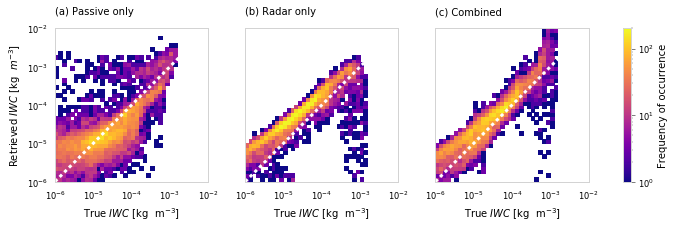

In [35]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm, Normalize
f = plt.figure(figsize = (9, 3))
gs = GridSpec(1, 4, width_ratios = [1.0, 1.0, 1.0, 0.05])
f, axs = plt.subplots(1, 3, figsize = (9, 3))
norm = LogNorm(1, 200)
#norm = Normalize(0, 100)

bins = np.logspace(-6, -2, 41)

ax = plt.subplot(gs[0])
x, y = qs_po["8-ColumnAggregate_None"]
img, x, y = np.histogram2d(x, y, bins)
ax.pcolormesh(x, y, img.T, cmap = "plasma", norm = norm)

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim([1e-6, 1e-2])
ax.set_ylim([1e-6, 1e-2])
ax.set_aspect(1)
ax.plot(bins, bins, c = "w", lw = 3, ls = ":")
ax.set_xlabel("True $IWC$ [kg  m$^{-3}$]")
ax.set_ylabel("Retrieved $IWC$ [kg  $m^{-3}$]")
ax.set_title("(a) Passive only", loc = "left")

ax = plt.subplot(gs[1])
x, y = qs_ro["GemSnow_None"]
img, x, y = np.histogram2d(x, y, bins)
ax.pcolormesh(x, y, img.T, cmap = "plasma", norm = norm)
x = 0.5 * (bins[1:] + bins[:-1])
#ax.contour(x, x, img.T, [20, 40, 60])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim([1e-6, 1e-2])
ax.set_ylim([1e-6, 1e-2])
ax.set_yticks([])
ax.set_aspect(1)
ax.set_xlabel("True $IWC$ [kg  m$^{-3}$]")
ax.plot(bins, bins, c = "w", lw = 3, ls = ":")
ax.set_title("(b) Radar only", loc = "left")

ax = plt.subplot(gs[2])
x, y = qs["GemSnow_None"]
img, x, y = np.histogram2d(x, y, bins)
img = ax.pcolormesh(x, y, img.T, cmap = "plasma", norm = norm)
x = 0.5 * (bins[1:] + bins[:-1])
#ax.contour(x, x, img.T, [20, 40, 60], colors = ["w"], linestyles = [":", "--", "-"])
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim([1e-6, 1e-2])
ax.set_ylim([1e-6, 1e-2])
ax.set_yticks([])
ax.set_aspect(1)
ax.set_xlabel("True $IWC$ [kg  m$^{-3}$]")
ax.plot(bins, bins, c = "w", lw = 3, ls = ":")
ax.set_title("(c) Combined", loc = "left")

plt.tight_layout()

ax = plt.subplot(gs[3])
plt.colorbar(img, cax = ax, label = "Frequency of occurrence")

### Scatter plots

In [36]:
# ice types
iwcs = np.stack([reference[k] for k in ["iwc", "swc", "gwc", "hwc"]])
ice_types = np.argmax(iwcs, axis = 0)
ice_types.shape

md = sum([reference[k] for k in ["iwc", "swc", "gwc", "hwc"]])
purity = np.max(iwcs, axis = 0) / md

/home/simonpf/build/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/home/simonpf/build/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


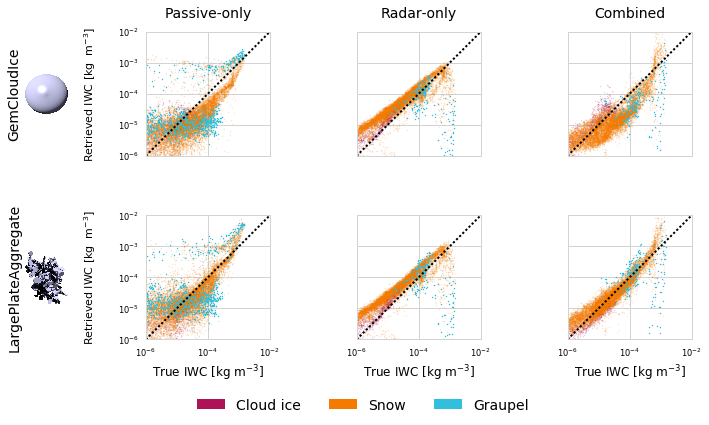

In [37]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors   import LogNorm
from matplotlib.patches  import Circle
from matplotlib.image    import imread
import matplotlib.path as mpath

hs = ["GemCloudIce_None", "LargePlateAggregate_None"]
particle_images = ["../../../plots/shape_img_gci.png",
                   "../../../plots/shape_img_lpa.png"]
n  = len(hs)
f  = plt.figure(figsize = (10, n * 3))
gs = GridSpec(n + 1, 4, width_ratios = [0.3, 1.0, 1.0, 1.0], height_ratios = [1.0] * n + [0.1])

# legend
handles = []
labels  = []
for i,l in enumerate(["Cloud ice", "Snow", "Graupel"]):
    handles += [Circle((0.0, 0.0), color = "C{}".format(i))]
    labels += [l]

ax = plt.subplot(gs[-1, :])
ax.legend(handles = handles,
          labels = labels,
          fontsize = 14,
          loc = "center",
         ncol = 4)
ax.set_axis_off()

#
# Habit types
#

for i, h in enumerate(hs):
    
    # Particle image
    ax = plt.subplot(gs[i, 0])
    img = os.path.join(particle_images[i])
    img = imread(img)
    ax.imshow(img)
    ax.xaxis.set_ticks([])
    for sp in ax.spines.values():
        sp.set_visible(False)
    ax.yaxis.set_ticks([])
    ax.set_aspect(1)
    ax.set_ylabel(h.split("_")[0], fontsize = 14)
    
    # Scatter plot
    for j, q in enumerate([qs_po, qs_ro, qs]):
        ax = plt.subplot(gs[i, j + 1])
        x, y = q[h]
        for k in range(4):
            inds = np.ravel(ice_types == k)
            plt.grid(zorder = 0)
            if k == 2:
                ax.scatter(x[inds], y[inds], c = "C{}".format(k), s = 2, alpha = 1, zorder = 1)
            else:
                ax.scatter(x[inds], y[inds], c = "C{}".format(k), s = 2, alpha = 0.2, zorder = 1)
            
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlim([1e-6, 1e-2])
        ax.set_ylim([1e-6, 1e-2])
        ax.set_aspect(1)
        ax.yaxis.labelpad = 20
        
        x = np.logspace(-6, -2, 101)
        ax.plot(x, x, c = "k", ls = ":", lw = 2)
        
        if j > 0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel("Retrieved IWC [kg  m$^{-3}$]", fontsize = 11)
            
        if i < n - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel("True IWC [kg m$^{-3}$]", fontsize = 12)
            
        if i == 0:
            titles = ["Passive-only",
                      "Radar-only",
                      "Combined"]
            ax.set_title(titles[j], fontsize = 14)
            
plt.tight_layout()

f.savefig("../../../plots/results_scatter_b_1.png", dpi = 300)

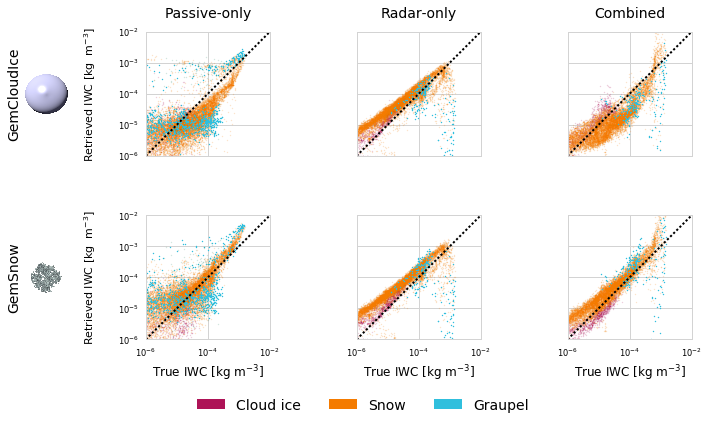

In [38]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors   import LogNorm
from matplotlib.patches  import Circle
from matplotlib.image    import imread
import matplotlib.path as mpath

hs = ["GemCloudIce_None", "GemSnow_None"]
particle_images = ["../../../plots/shape_img_gci.png",
                   "../../../plots/shape_img_gs.png"]
n  = len(hs)
f  = plt.figure(figsize = (10, n * 3))
gs = GridSpec(n + 1, 4, width_ratios = [0.3, 1.0, 1.0, 1.0], height_ratios = [1.0] * n + [0.1])

# legend
handles = []
labels  = []
for i,l in enumerate(["Cloud ice", "Snow", "Graupel"]):
    handles += [Circle((0.0, 0.0), color = "C{}".format(i))]
    labels += [l]

ax = plt.subplot(gs[-1, :])
ax.legend(handles = handles,
          labels = labels,
          fontsize = 14,
          loc = "center",
         ncol = 4)
ax.set_axis_off()

#
# Habit types
#

for i, h in enumerate(hs):
    
    # Particle image
    ax = plt.subplot(gs[i, 0])
    img = os.path.join(particle_images[i])
    img = imread(img)
    ax.imshow(img)
    ax.xaxis.set_ticks([])
    for sp in ax.spines.values():
        sp.set_visible(False)
    ax.yaxis.set_ticks([])
    ax.set_aspect(1)
    ax.set_ylabel(h.split("_")[0], fontsize = 14)
    
    # Scatter plot
    for j, q in enumerate([qs_po, qs_ro, qs]):
        ax = plt.subplot(gs[i, j + 1])
        x, y = q[h]
        for k in range(4):
            inds = np.ravel(ice_types == k)
            plt.grid(zorder = 0)
            if k == 2:
                ax.scatter(x[inds], y[inds], c = "C{}".format(k), s = 2, alpha = 1, zorder = 1)
            else:
                ax.scatter(x[inds], y[inds], c = "C{}".format(k), s = 2, alpha = 0.2, zorder = 1)
            
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlim([1e-6, 1e-2])
        ax.set_ylim([1e-6, 1e-2])
        ax.set_aspect(1)
        ax.yaxis.labelpad = 20
        
        x = np.logspace(-6, -2, 101)
        ax.plot(x, x, c = "k", ls = ":", lw = 2)
        
        if j > 0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel("Retrieved IWC [kg  m$^{-3}$]", fontsize = 11)
            
        if i < n - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel("True IWC [kg m$^{-3}$]", fontsize = 12)
            
        if i == 0:
            titles = ["Passive-only",
                      "Radar-only",
                      "Combined"]
            ax.set_title(titles[j], fontsize = 14)
            
plt.tight_layout()

f.savefig("../../../plots/results_scatter_b_1_s.png", dpi = 300)

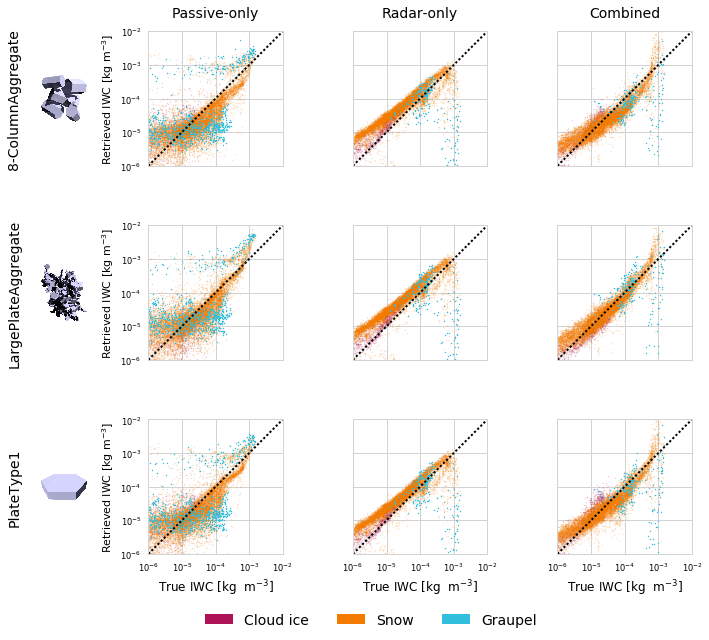

In [39]:
from matplotlib.colors   import LogNorm
from matplotlib.patches  import Circle
from matplotlib.image    import imread
import matplotlib.path as mpath

hs = ["8-ColumnAggregate_None", "LargePlateAggregate_None", "PlateType1_None"]
particle_images = [ "../../../plots/shape_img_8ca.png",
                   "../../../plots/shape_img_lpa.png",
                   "../../../plots/shape_img_pt1.png"]
n  = len(hs)
f  = plt.figure(figsize = (10, n * 3))
gs = GridSpec(n + 1, 4, width_ratios = [0.3, 1.0, 1.0, 1.0], height_ratios = [1.0] * n + [0.1])

# legend
handles = []
labels  = []
for i,l in enumerate(["Cloud ice", "Snow", "Graupel"]):
    handles += [Circle((0.0, 0.0), color = "C{}".format(i))]
    labels += [l]

ax = plt.subplot(gs[-1, :])
ax.legend(handles = handles,
          labels = labels,
          fontsize = 14,
          loc = "center",
         ncol = 4)
ax.set_axis_off()

#
# Habit types
#

for i, h in enumerate(hs):
    
    # Particle image
    ax = plt.subplot(gs[i, 0])
    img = os.path.join(particle_images[i])
    img = imread(img)
    ax.imshow(img)
    ax.xaxis.set_ticks([])
    for sp in ax.spines.values():
        sp.set_visible(False)
    ax.yaxis.set_ticks([])
    ax.set_aspect(1)
    ax.set_ylabel(h.split("_")[0], fontsize = 14)
    ax.yaxis.labelpad = 20
    
    # Scatter plot
    for j, q in enumerate([qs_po, qs_ro, qs]):
        ax = plt.subplot(gs[i, j + 1])
        x, y = q[h]
        for k in range(4):
            inds = np.ravel(ice_types == k)
            plt.grid(zorder = 0)
            if k == 2:
                ax.scatter(x[inds], y[inds], c = "C{}".format(k), s = 2, alpha = 1.0, zorder = 1)
            else:
                ax.scatter(x[inds], y[inds], c = "C{}".format(k), s = 2, alpha = 0.2, zorder = 1)
            
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlim([1e-6, 1e-2])
        ax.set_ylim([1e-6, 1e-2])
        ax.set_aspect(1)
        
        x = np.logspace(-6, -2, 101)
        ax.plot(x, x, c = "k", ls = ":", lw = 2)
        
        if j > 0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel("Retrieved IWC [kg m$^{-3}$]", fontsize = 11)
            
        if i < n - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel("True IWC [kg  m$^{-3}$]", fontsize = 12)
            
        if i == 0:
            titles = ["Passive-only",
                      "Radar-only",
                      "Combined"]
            ax.set_title(titles[j], fontsize = 14)
            
plt.tight_layout()

f.savefig("../../../plots/results_scatter_b_2.png", dpi = 300)

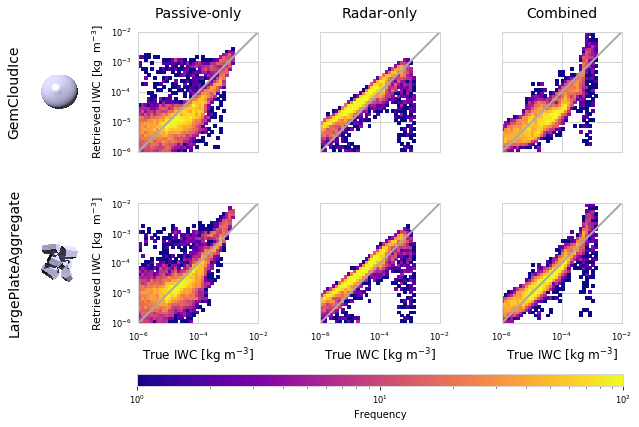

In [13]:
from matplotlib.colors   import LogNorm
from matplotlib.patches  import Circle
from matplotlib.image    import imread
from matplotlib.cm import ScalarMappable
import matplotlib.path as mpath

hs = ["GemCloudIce_None", "LargePlateAggregate_None"]
particle_images = [ "../../../plots/shape_img_gci.png",
                   "../../../plots/shape_img_8ca.png"]
n  = len(hs)
f  = plt.figure(figsize = (9, n * 3))
gs = GridSpec(n + 1, 4, width_ratios = [0.3, 1.0, 1.0, 1.0], height_ratios = [1.0] * n + [0.1])
norm = LogNorm(1, 100)



# legend
sm = ScalarMappable(norm = norm, cmap = "plasma")
sm.set_array(np.linspace(0, 100, 101))
ax = plt.subplot(gs[-1, 1:])
plt.colorbar(sm, orientation = "horizontal", label = "Frequency", cax = ax)

#
# Habit types
#

for i, h in enumerate(hs):
    
    # Particle image
    ax = plt.subplot(gs[i, 0])
    img = os.path.join(particle_images[i])
    img = imread(img)
    ax.imshow(img)
    ax.xaxis.set_ticks([])
    for sp in ax.spines.values():
        sp.set_visible(False)
    ax.yaxis.set_ticks([])
    ax.set_aspect(1)
    ax.set_ylabel(h.split("_")[0], fontsize = 14)
    ax.yaxis.labelpad = 20
    
    # Scatter plot
    for j, q in enumerate([qs_po, qs_ro, qs]):
        ax = plt.subplot(gs[i, j + 1])
        x, y = q[h]
        bins = np.logspace(-6, -2, 41)
        img, x, y = np.histogram2d(x, y, bins)
        ax.pcolormesh(x, y, img.T, cmap = "plasma", norm = norm)
        plt.grid(zorder = 0)
            
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlim([1e-6, 1e-2])
        ax.set_ylim([1e-6, 1e-2])
        ax.set_aspect(1)
        
        x = np.logspace(-6, -2, 101)
        ax.plot(x, x, lw = 2, c = "darkgray")
        
        if j > 0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel("Retrieved IWC [kg  m$^{-3}$]", fontsize = 11)
            
        if i < n - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel("True IWC [kg m$^{-3}$]", fontsize = 12)
            
        if i == 0:
            titles = ["Passive-only",
                      "Radar-only",
                      "Combined"]
            ax.set_title(titles[j], fontsize = 14)
            
plt.tight_layout()
f.savefig("../../../plots/results_hist_a.png", dpi = 300)

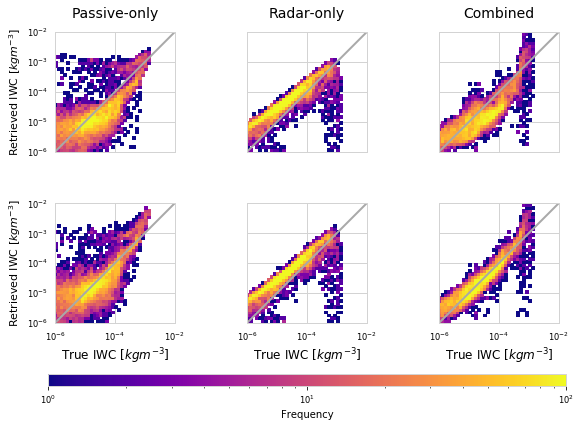

In [14]:
from matplotlib.colors   import LogNorm
from matplotlib.patches  import Circle
from matplotlib.image    import imread
from matplotlib.cm import ScalarMappable
import matplotlib.path as mpath

hs = ["GemCloudIce_None", "LargePlateAggregate_None"]
particle_images = [ "../../../plots/shape_img_gci.png",
                   "../../../plots/shape_img_8ca.png"]
n  = len(hs)
f  = plt.figure(figsize = (9, n * 3))
gs = GridSpec(n + 1, 4, width_ratios = [0.3, 1.0, 1.0, 1.0], height_ratios = [1.0] * n + [0.1])
norm = LogNorm(1, 100)



# legend
sm = ScalarMappable(norm = norm, cmap = "plasma")
sm.set_array(np.linspace(0, 100, 101))
ax = plt.subplot(gs[-1, 1:])
plt.colorbar(sm, orientation = "horizontal", label = "Frequency", cax = ax)

#
# Habit types
#

for i, h in enumerate(hs):
    
    # Scatter plot
    for j, q in enumerate([qs_po, qs_ro, qs]):
        ax = plt.subplot(gs[i, j + 1])
        x, y = q[h]
        bins = np.logspace(-6, -2, 41)
        img, x, y = np.histogram2d(x, y, bins)
        ax.pcolormesh(x, y, img.T, cmap = "plasma", norm = norm)
        plt.grid(zorder = 0)
            
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlim([1e-6, 1e-2])
        ax.set_ylim([1e-6, 1e-2])
        ax.set_aspect(1)
        
        x = np.logspace(-6, -2, 101)
        ax.plot(x, x, lw = 2, c = "darkgray")
        
        if j > 0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel("Retrieved IWC [$kg m^{-3}$]", fontsize = 11)
            
        if i < n - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel("True IWC [$kg m^{-3}$]", fontsize = 12)
            
        if i == 0:
            titles = ["Passive-only",
                      "Radar-only",
                      "Combined"]
            ax.set_title(titles[j], fontsize = 14)
            
plt.tight_layout()

f.savefig("../../../plots/results_hist_b.png", dpi = 300)

<Figure size 576x288 with 0 Axes>

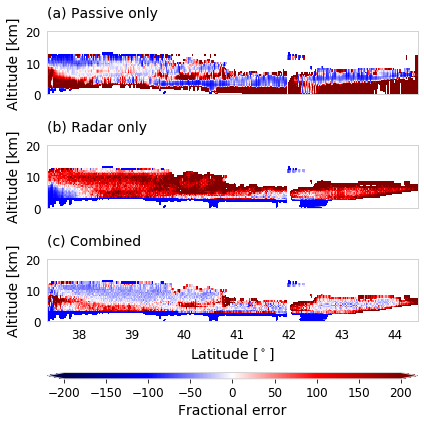

In [15]:
from matplotlib.colors import Normalize

from matplotlib.cm import seismic

f = plt.figure(figsize = (8, 4))

lats = reference["lat"][:800]
z    = reference["z"][:800]
name = "Mass density [$kg/m^3$]"
norm = Normalize(-200, 200)
cmap = seismic
titles = ["Passive only", "Radar only", "Combined"]
rs    = results["LargePlateAggregate_None"]
rs_po = results_po["LargePlateAggregate_None"]
rs_ro = results_ro["LargePlateAggregate_None"]

r = np.maximum(reference["iwc"] + reference["swc"] + reference["hwc"] + reference["gwc"], 1e-8)[:800, :]

qs = []
m = iwc(rs_po["ice_n0"], rs_po["ice_dm"])[:800, :]
inds = np.logical_and(m < 1e-5, r < 1e-6)
dm = (m - r) / r
dm[inds] = np.nan
qs += [dm * 100]

m = iwc(rs_ro["ice_n0"], rs_ro["ice_dm"])[:800, :]
inds = np.logical_and(m < 1e-5, r < 1e-6)
dm = (m - r) / r
dm[inds] = np.nan
qs += [dm * 100]

m = iwc(rs["ice_n0"], rs["ice_dm"])[:800, :]
inds = np.logical_and(m < 1e-5, r < 1e-6)
dm = (m - r) / r
dm[inds] = np.nan
qs += [dm * 100]
        
plt.figure(figsize = (6, 6))
f = plot_results(lats, z, qs, "Fractional error", norm, cmap = cmap, titles = titles)
f.savefig("../../../plots/fes_scene_b.png", bbox_inches = "tight")

## Number densities

In [18]:
from mcrf.psds import D14NDmIce
psd = D14NDmIce()
def number_density(n0, dm):
    psd.mass_weighted_diameter = dm
    psd.intercept_parameter = n0
    return psd.get_moment(0)

GemCloudIce_None


/home/simonpf/build/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


IceSphere_None


KeyError: '8-ColumnAggregate_LargePlateAggregate'

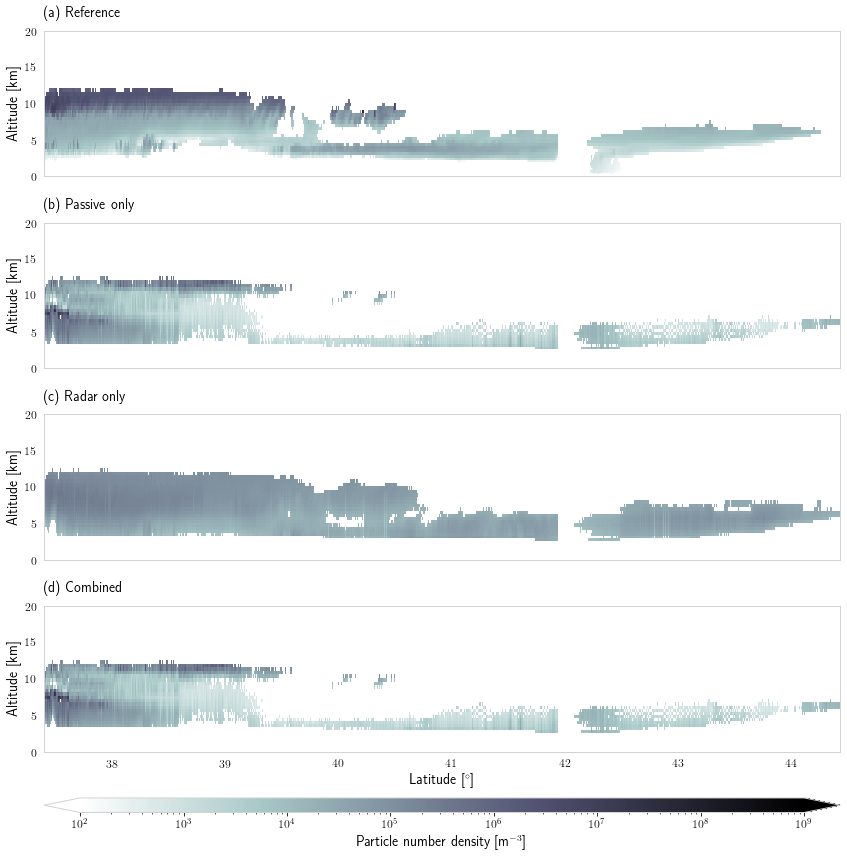

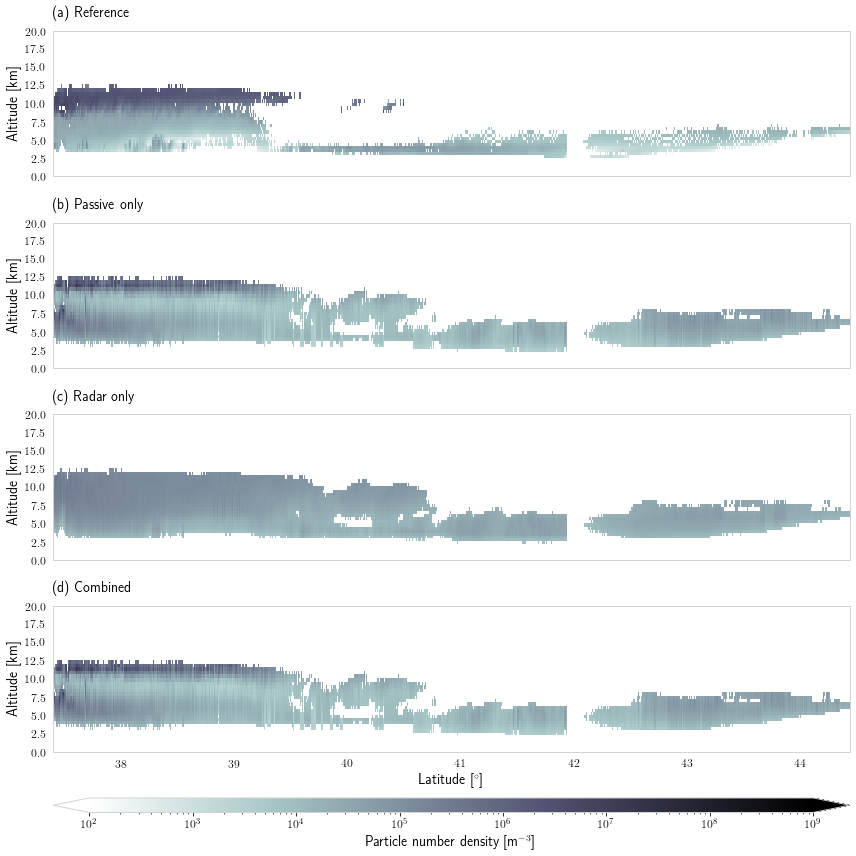

In [19]:
from matplotlib.colors import LogNorm
from matplotlib.cm import bone_r
lats = reference["lat"]
z    = reference["z"]
name = "Particle number density [m$^{-3}$]"
norm = LogNorm(1e2, 1e9)
cmap = bone_r
titles = ["Reference", "Passive only", "Radar only", "Combined"]
md = np.maximum(reference["iwc"] + reference["swc"] \
                + reference["hwc"] + reference["gwc"], 1e-8)
cmap.set_bad("white")

for h in [h for h in results.keys()]:
    rs    = results[h]
    rs_po = results[h]
    rs_ro = results_ro[h]
    print(h)
    
    costs = []
    costs += [rs_po["diagnostics"][:, 3]]
    costs += [rs_ro["diagnostics"][:, 3]]
    costs += [rs["diagnostics"][:, 3]]
    
    qs = []
    
    qs += [np.maximum(reference["iwc_nd"] + reference["swc_nd"] \
                      + reference["hwc_nd"] + reference["gwc_nd"], 1e-8)]
    inds = md < 1e-5
    qs[-1][inds] = np.nan
    
    md = iwc(rs_po["ice_n0"], rs_po["ice_dm"])
    inds = md < 1e-5
    qs += [number_density(rs_po["ice_n0"], rs_po["ice_dm"])]
    if not rs_po["snow_n0"] is None:
        qs[-1] += number_density(rs_po["snow_n0"], rs_po["snow_dm"])
    qs[-1][inds] = np.nan
        
    md = iwc(rs_ro["ice_n0"], rs_ro["ice_dm"])
    inds = md < 1e-5
    qs += [number_density(rs_ro["ice_n0"], rs_ro["ice_dm"])]
    if not rs_ro["snow_n0"] is None:
        qs[-1] += number_density(rs_ro["snow_n0"], rs_ro["snow_dm"])
    qs[-1][inds] = np.nan
    
    md = iwc(rs["ice_n0"], rs["ice_dm"])
    inds = md < 1e-5
    qs += [number_density(rs["ice_n0"], rs["ice_dm"])]
    if not rs["snow_n0"] is None:
        qs[-1] += number_density(rs["snow_n0"], rs["snow_dm"])
    md = iwc(rs["ice_n0"], rs["ice_dm"])
    qs[-1][inds] = np.nan
        
    for ax in f.axes[:-1]:
        ax.set_yticks([0, 5, 10, 15, 20])
        
    f = plt.figure(figsize = (12, 12))
    plot_results(lats, z, qs, name, norm, cmap = cmap, titles = titles)
    if "None" in h:
        f.savefig("../../../plots/results_nd_b_" + h[:-5] + ".png", bbox_inches = "tight")
    else:
        f.savefig("../../../plots/results_nd_b_" + h + ".png", bbox_inches = "tight")


In [43]:
qs = {}
qs_ro = {}
qs_po = {}

q_r  = np.maximum(reference["iwc_nd"] + reference["swc_nd"] + reference["hwc_nd"] + reference["gwc_nd"], 1e-8)
md_r = np.maximum(reference["iwc"] + reference["swc"] + reference["hwc"] + reference["gwc"], 1e-8)

for h in results.keys():
    rs   = results[h]
    q    = number_density(rs["ice_n0"], rs["ice_dm"]).data
    qs[h] = (q_r.ravel(), q.ravel())
    
    rs   = results_po[h]
    q    = number_density(rs["ice_n0"], rs["ice_dm"]).data
    qs_po[h] = (q_r.ravel(), q.ravel())

    rs   = results_ro[h]
    q    = number_density(rs["ice_n0"], rs["ice_dm"]).data
    qs_ro[h] = (q_r.ravel(), q.ravel())

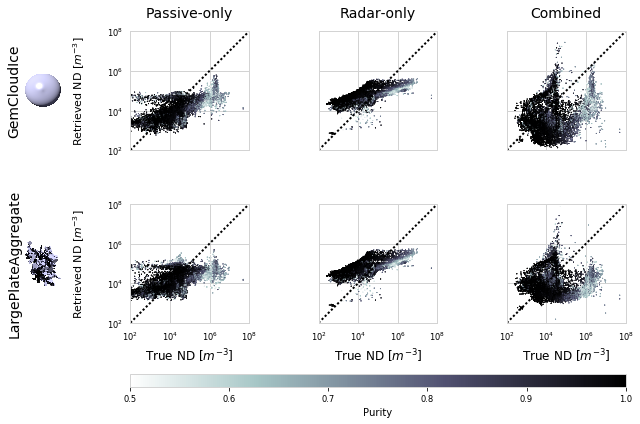

In [44]:
from matplotlib.gridspec import GridSpec
from matplotlib.cm       import ScalarMappable
from matplotlib.colors   import LogNorm
from matplotlib.patches  import Circle
from matplotlib.image    import imread
import matplotlib.path as mpath

#hs = ["GemCloudIce_None", "GemSnow_None"]
#particle_images = ["../../../plots/shape_img_gci.png",
#                   "../../../plots/shape_img_gs.png"]
hs = ["GemCloudIce_None", "LargePlateAggregate_None"]
particle_images = [ "../../../plots/shape_img_gci.png",
                   "../../../plots/shape_img_lpa.png"]
n  = len(hs)
n  = len(hs)
f  = plt.figure(figsize = (9, n * 3))
gs = GridSpec(n + 1, 4, width_ratios = [0.3, 1.0, 1.0, 1.0], height_ratios = [1.0] * n + [0.1])
norm = Normalize(0.5, 1)
cmap = "bone_r"

# Color bar
sm = ScalarMappable(norm = norm, cmap = bone_r)
sm.set_array(purity)
ax = plt.subplot(gs[-1, 1:])
plt.colorbar(sm, orientation = "horizontal", label = "Purity", cax = ax)

#
# Habit types
#

for i, h in enumerate(hs):
    
    # Particle image
    ax = plt.subplot(gs[i, 0])
    img = os.path.join(particle_images[i])
    img = imread(img)
    ax.imshow(img)
    ax.xaxis.set_ticks([])
    for sp in ax.spines.values():
        sp.set_visible(False)
    ax.yaxis.set_ticks([])
    ax.set_aspect(1)
    ax.set_ylabel(h.split("_")[0], fontsize = 14)
    
    # Scatter plot
    for j, q in enumerate([qs_po, qs_ro, qs]):
        ax = plt.subplot(gs[i, j + 1])
        x, y = q[h]
        for k in range(4):
            #inds = np.ravel(ice_types == k)
            p = np.ravel(purity)
            inds = np.ravel(md_r) > 1e-5
            plt.grid(zorder = 0)
            #if k == 2:
            #    ax.scatter(x[inds], y[inds], c = "C{}".format(k), s = 4, alpha = 1, zorder = 1)
            #else:
            #    ax.scatter(x[inds], y[inds], c = "C{}".format(k), s = 2, alpha = 0.3, zorder = 1)
            #ax.scatter(x, y, c = purity.ravel(), s = 4, alpha = 1, zorder = 1)
            ax.scatter(x[inds], y[inds], c = p[inds], s = 1, alpha = 1.0, zorder = 1,
                       norm = norm, cmap = "bone_r")
            
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlim([1e2, 1e8])
        ax.set_ylim([1e2, 1e8])
        ax.set_aspect(1)
        ax.yaxis.labelpad = 20
        
        x = np.logspace(2, 9, 101)
        ax.plot(x, x, c = "k", ls = ":", lw = 2)
        
        if j > 0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel("Retrieved ND [$m^{-3}$]", fontsize = 11)
            
        if i < n - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel("True ND [$m^{-3}$]", fontsize = 12)
            
        if i == 0:
            titles = ["Passive-only",
                      "Radar-only",
                      "Combined"]
            ax.set_title(titles[j], fontsize = 14)
            
plt.tight_layout()

f.savefig("../../../plots/results_nd_scatter_b.png", dpi = 300)

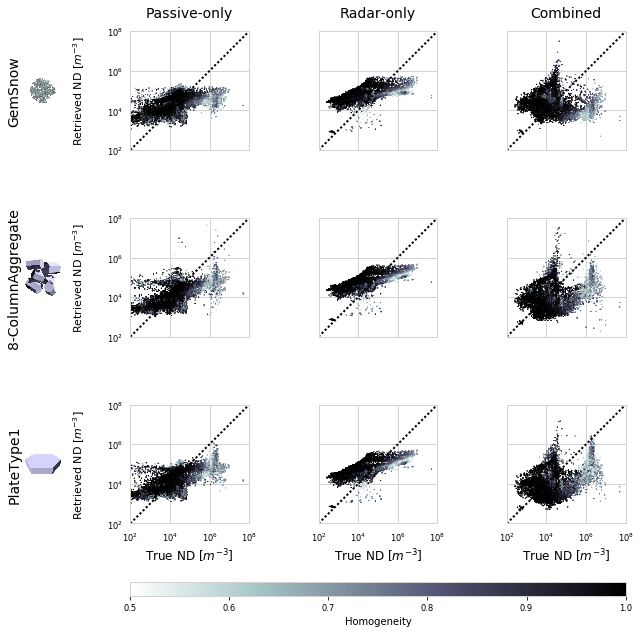

In [45]:
from matplotlib.gridspec import GridSpec
from matplotlib.cm       import ScalarMappable
from matplotlib.colors   import LogNorm
from matplotlib.patches  import Circle
from matplotlib.image    import imread
import matplotlib.path as mpath

#hs = ["GemCloudIce_None", "GemSnow_None"]
#particle_images = ["../../../plots/shape_img_gci.png",
#                   "../../../plots/shape_img_gs.png"]
hs = ["GemSnow_None", "8-ColumnAggregate_None", "PlateType1_None"]
particle_images = ["../../../plots/shape_img_gs.png",
                   "../../../plots/shape_img_8ca.png",
                   "../../../plots/shape_img_pt1.png"]
n  = len(hs)
n  = len(hs)
f  = plt.figure(figsize = (9, n * 3))
gs = GridSpec(n + 1, 4, width_ratios = [0.3, 1.0, 1.0, 1.0], height_ratios = [1.0] * n + [0.1])
norm = Normalize(0.5, 1)
cmap = "bone_r"

# Color bar
sm = ScalarMappable(norm = norm, cmap = bone_r)
sm.set_array(purity)
ax = plt.subplot(gs[-1, 1:])
plt.colorbar(sm, orientation = "horizontal", label = "Homogeneity", cax = ax)

#
# Habit types
#

for i, h in enumerate(hs):
    
    # Particle image
    ax = plt.subplot(gs[i, 0])
    img = os.path.join(particle_images[i])
    img = imread(img)
    ax.imshow(img)
    ax.xaxis.set_ticks([])
    for sp in ax.spines.values():
        sp.set_visible(False)
    ax.yaxis.set_ticks([])
    ax.set_aspect(1)
    ax.set_ylabel(h.split("_")[0], fontsize = 14)
    
    # Scatter plot
    for j, q in enumerate([qs_po, qs_ro, qs]):
        ax = plt.subplot(gs[i, j + 1])
        x, y = q[h]
        for k in range(4):
            #inds = np.ravel(ice_types == k)
            p = np.ravel(purity)
            inds = np.ravel(md_r) > 1e-5
            plt.grid(zorder = 0)
            #if k == 2:
            #    ax.scatter(x[inds], y[inds], c = "C{}".format(k), s = 4, alpha = 1, zorder = 1)
            #else:
            #    ax.scatter(x[inds], y[inds], c = "C{}".format(k), s = 2, alpha = 0.3, zorder = 1)
            #ax.scatter(x, y, c = purity.ravel(), s = 4, alpha = 1, zorder = 1)
            ax.scatter(x[inds], y[inds], c = p[inds], s = 1, alpha = 1.0, zorder = 1,
                       norm = norm, cmap = "bone_r")
            
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlim([1e2, 1e8])
        ax.set_ylim([1e2, 1e8])
        ax.set_aspect(1)
        ax.yaxis.labelpad = 20
        
        x = np.logspace(2, 9, 101)
        ax.plot(x, x, c = "k", ls = ":", lw = 2)
        
        if j > 0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel("Retrieved ND [$m^{-3}$]", fontsize = 11)
            
        if i < n - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel("True ND [$m^{-3}$]", fontsize = 12)
            
        if i == 0:
            titles = ["Passive-only",
                      "Radar-only",
                      "Combined"]
            ax.set_title(titles[j], fontsize = 14)
            
plt.tight_layout()

f.savefig("../../../plots/results_nd_scatter_b_1.png", dpi = 300)

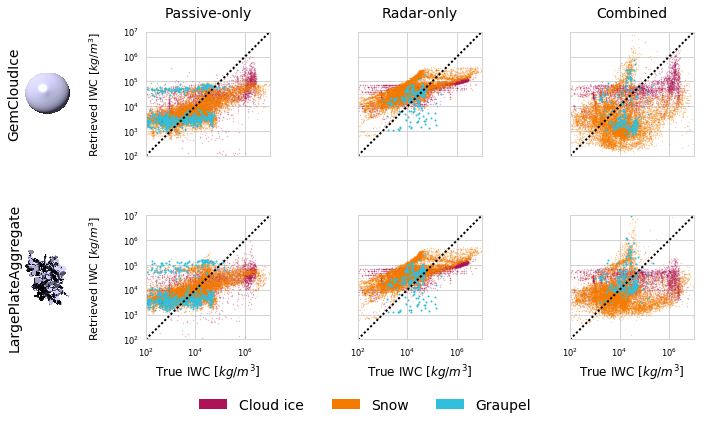

In [21]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors   import LogNorm
from matplotlib.patches  import Circle
from matplotlib.image    import imread
import matplotlib.path as mpath

n  = len(hs)
f  = plt.figure(figsize = (10, n * 3))
gs = GridSpec(n + 1, 4, width_ratios = [0.3, 1.0, 1.0, 1.0], height_ratios = [1.0] * n + [0.1])

# legend
handles = []
labels  = []
for i,l in enumerate(["Cloud ice", "Snow", "Graupel"]):
    handles += [Circle((0.0, 0.0), color = "C{}".format(i))]
    labels += [l]

ax = plt.subplot(gs[-1, :])
ax.legend(handles = handles,
          labels = labels,
          fontsize = 14,
          loc = "center",
         ncol = 4)
ax.set_axis_off()

#
# Habit types
#

for i, h in enumerate(hs):
    
    # Particle image
    ax = plt.subplot(gs[i, 0])
    img = os.path.join(particle_images[i])
    img = imread(img)
    ax.imshow(img)
    ax.xaxis.set_ticks([])
    for sp in ax.spines.values():
        sp.set_visible(False)
    ax.yaxis.set_ticks([])
    ax.set_aspect(1)
    ax.set_ylabel(h.split("_")[0], fontsize = 14)
    
    # Scatter plot
    for j, q in enumerate([qs_po, qs_ro, qs]):
        ax = plt.subplot(gs[i, j + 1])
        x, y = q[h]
        for k in range(4):
            inds = np.ravel(ice_types == k)
            plt.grid(zorder = 0)
            if k == 2:
                ax.scatter(x[inds], y[inds], c = "C{}".format(k), s = 4, alpha = 1, zorder = 1)
            else:
                ax.scatter(x[inds], y[inds], c = "C{}".format(k), s = 2, alpha = 0.3, zorder = 1)
            
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlim([1e2, 1e7])
        ax.set_ylim([1e2, 1e7])
        ax.set_aspect(1)
        ax.yaxis.labelpad = 20
        
        x = np.logspace(2, 9, 101)
        ax.plot(x, x, c = "k", ls = ":", lw = 2)
        
        if j > 0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel("Retrieved IWC [$kg / m^3$]", fontsize = 11)
            
        if i < n - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel("True IWC [$kg / m^3$]", fontsize = 12)
            
        if i == 0:
            titles = ["Passive-only",
                      "Radar-only",
                      "Combined"]
            ax.set_title(titles[j], fontsize = 14)
            
plt.tight_layout()

f.savefig("../../../plots/results_nd_scatter_b_1.png", dpi = 300)

<Figure size 576x288 with 0 Axes>

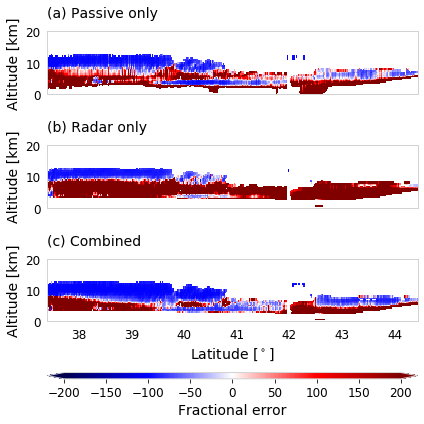

In [22]:
from matplotlib.colors import Normalize
from matplotlib.cm import seismic

f = plt.figure(figsize = (8, 4))

lats = reference["lat"][:800]
z    = reference["z"][:800]
name = "Mass density [$kg/m^3$]"
norm = Normalize(-200, 200)
cmap = seismic
titles = ["Passive only", "Radar only", "Combined"]
rs    = results["LargePlateAggregate_None"]
rs_po = results_po["LargePlateAggregate_None"]
rs_ro = results_ro["LargePlateAggregate_None"]

mr = np.maximum(reference["iwc"] + reference["swc"]
               + reference["hwc"] + reference["gwc"], 1e-8)[:800, :]
r = np.maximum(reference["iwc_nd"] + reference["swc_nd"]
               + reference["hwc_nd"] + reference["gwc_nd"], 1e-8)[:800, :]

qs = []
m = iwc(rs_po["ice_n0"], rs_po["ice_dm"])
nd = number_density(rs_po["ice_n0"], rs_po["ice_dm"])
inds = np.logical_or(m < 1e-6, mr < 1e-6)
dm = (nd - r) / r
dm[inds] = np.nan
qs += [dm * 100]

m = iwc(rs_ro["ice_n0"], rs_ro["ice_dm"])
nd = number_density(rs_ro["ice_n0"], rs_ro["ice_dm"])
inds = np.logical_or(m < 1e-6, mr < 1e-6)
dm = (nd - r) / r
dm[inds] = np.nan
qs += [dm * 100]

m = iwc(rs["ice_n0"], rs["ice_dm"])
nd = number_density(rs["ice_n0"], rs["ice_dm"])
inds = np.logical_or(m < 1e-6, mr < 1e-6)
dm = (nd - r) / r
dm[inds] = np.nan
qs += [dm * 100]
        
plt.figure(figsize = (6, 6))
f = plot_results(lats, z, qs, "Fractional error", norm, cmap = cmap, titles = titles)
f.savefig("../../../plots/fes_nd_scene_b.png", bbox_inches = "tight")

# Integrated masses


In [23]:
qs = {}
qs_ro = {}
qs_po = {}

q_r  = np.maximum(reference["iwc"] + reference["swc"] + reference["hwc"] + reference["gwc"], 1e-8)
q_r  = np.trapz(q_r, x = z)
md_r = np.maximum(reference["iwc"] + reference["swc"] + reference["hwc"] + reference["gwc"], 1e-8)

for h in results.keys():
    rs   = results[h]
    q    = iwc(rs["ice_n0"], rs["ice_dm"]).data
    q    = np.trapz(q, x = z)
    qs[h] = (q_r.ravel(), q.ravel())
    
    rs   = results_po[h]
    q    = iwc(rs["ice_n0"], rs["ice_dm"]).data
    q    = np.trapz(q, x = z)
    qs_po[h] = (q_r.ravel(), q.ravel())

    rs   = results_ro[h]
    q    = iwc(rs["ice_n0"], rs["ice_dm"]).data
    q    = np.trapz(q, x = z)
    qs_ro[h] = (q_r.ravel(), q.ravel())

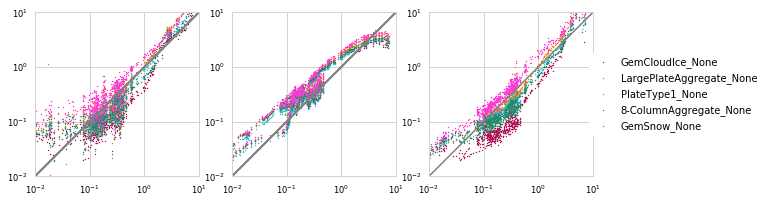

In [24]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors   import LogNorm
from matplotlib.patches  import Circle
from matplotlib.image    import imread
import matplotlib.path as mpath

f  = plt.figure(figsize = (10, n * 3))
gs = GridSpec(1, 3, width_ratios = [1.0, 1.0, 1.0])

hs = [k for k in results.keys() if "None" in k]
ax = plt.subplot(gs[0])
for h in hs:
    q_r, q = qs_po[h]
    ax.scatter(q_r, q, s = 2)
    ax.set_xscale("log")
    ax.set_yscale("log")
    
    x = np.logspace(-3, 3, 101)
    ax.plot(x, x, c = "grey")
    
    ax.set_xlim([1e-2, 1e1])
    ax.set_ylim([1e-2, 1e1])
    ax.set_aspect(1.0)
    
ax = plt.subplot(gs[1])
for h in hs:
    q_r, q = qs_ro[h]
    ax.scatter(q_r, q, s = 2)
    ax.set_xscale("log")
    ax.set_yscale("log")
    
    x = np.logspace(-3, 3, 101)
    ax.plot(x, x, c = "grey")
    
    ax.set_xlim([1e-2, 1e1])
    ax.set_ylim([1e-2, 1e1])
    ax.set_aspect(1.0)
    
ax = plt.subplot(gs[2])
for h in hs:
    q_r, q = qs[h]
    ax.scatter(q_r, q, s = 2, label = h)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim([1e-2, 1e1])
    ax.set_ylim([1e-2, 1e1])
    
x = np.logspace(-3, 3, 101)
ax.plot(x, x, c = "grey")

ax.set_aspect(1.0)
ax.legend(loc = "center", bbox_to_anchor = [1.5, 0.5])

(-100, 100)

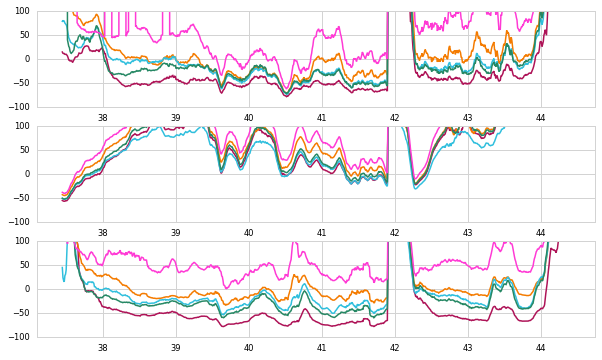

In [25]:

from matplotlib.gridspec import GridSpec
from matplotlib.colors   import LogNorm
from matplotlib.patches  import Circle
from matplotlib.image    import imread
import scipy as sp
import scipy.signal
import matplotlib.path as mpath

f  = plt.figure(figsize = (10, n * 3))
gs = GridSpec(3, 1, height_ratios = [1.0, 1.0, 1.0])
k = np.ones(10) / 10

hs = [k for k in results.keys() if "None" in k]
ax = plt.subplot(gs[0])
for h in hs:
    q_r, q = qs_po[h]
    x = sp.signal.convolve(lats, k, "valid")
    y = sp.signal.convolve(100 * (q - q_r) / q_r, k, "valid")
    ax.plot(x, y)
ax.set_ylim([-100, 100])
    
    
ax = plt.subplot(gs[1])
for h in hs:
    q_r, q = qs_ro[h]
    x = sp.signal.convolve(lats, k, "valid")
    y = sp.signal.convolve(100 * (q - q_r) / q_r, k, "valid")
    ax.plot(x, y)
ax.set_ylim([-100, 100])
    
ax = plt.subplot(gs[2])
for h in hs:
    q_r, q = qs[h]
    x = sp.signal.convolve(lats, k, "valid")
    y = sp.signal.convolve(100 * (q - q_r) / q_r, k, "valid")
    ax.plot(x, y)
ax.set_ylim([-100, 100])

## Relative humidity

In [47]:
data_provider = ModelDataProvider(99, "B")
t = np.zeros((800, 58))
p = np.zeros((800, 58))
for i in range(800):
    t[i, :] = data_provider.get_temperature(2200 + i)
    t[i, :] = data_provider.get_pressure(2200 + i)

def p_eq(t):
    p = np.zeros(t.shape)

    
    inds = t >= 273.15
    tt = np.exp( 54.842763 - 6763.22 / t - 4.21 * np.log(t) + 0.000367 * t + \
                 np.tanh(0.0415 * (t - 218.8)) * ( 53.878 - 1331.22/t - \
                                                   9.44523 * np.log(t) + 0.014025 * t) );
    p[inds] = tt[inds]

    inds = t < 273.15
    tt = np.exp(9.550426 - 5723.265 / t + 3.53068 * np.log(t) - 0.00728332 * t);
    p[inds] = tt[inds]
    return p

GemCloudIce_None
109.99976
IceSphere_None
93.7096
LargePlateAggregate_None
93.57213
LargeColumnAggregate_None
92.91904
PlateType1_None
109.99986
SectorSnowflake_None
93.69541
8-ColumnAggregate_None
93.673935
GemSnow_None
109.99979


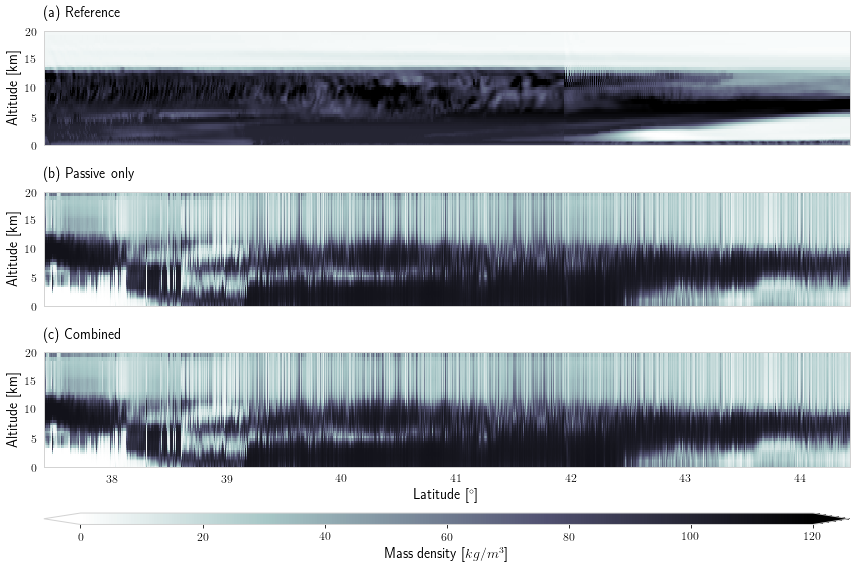

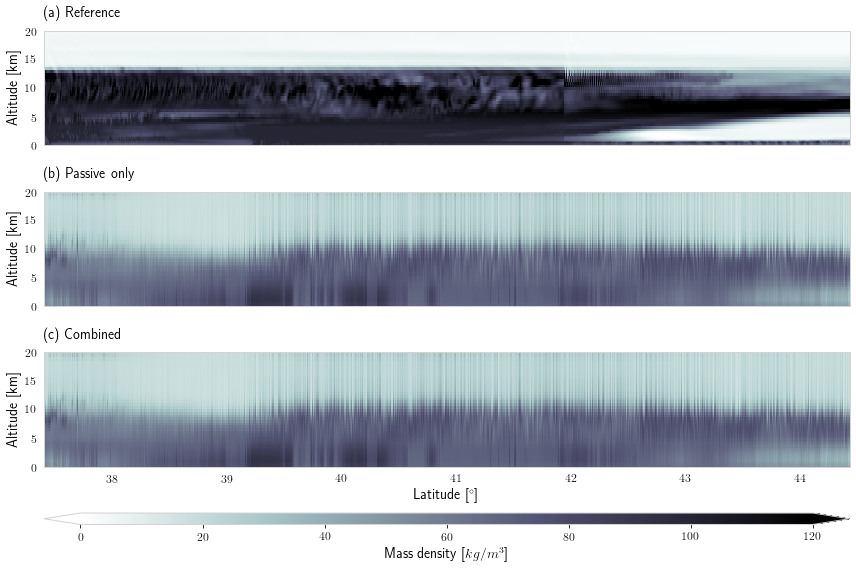

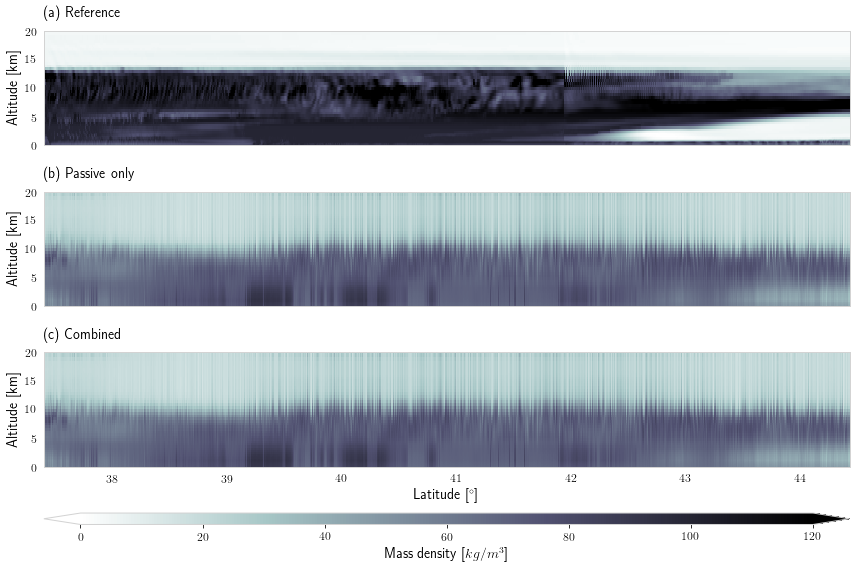

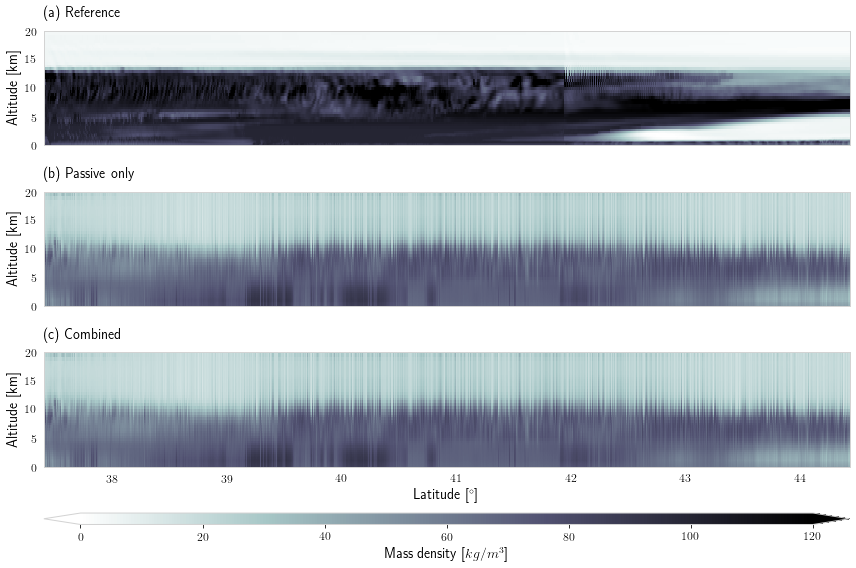

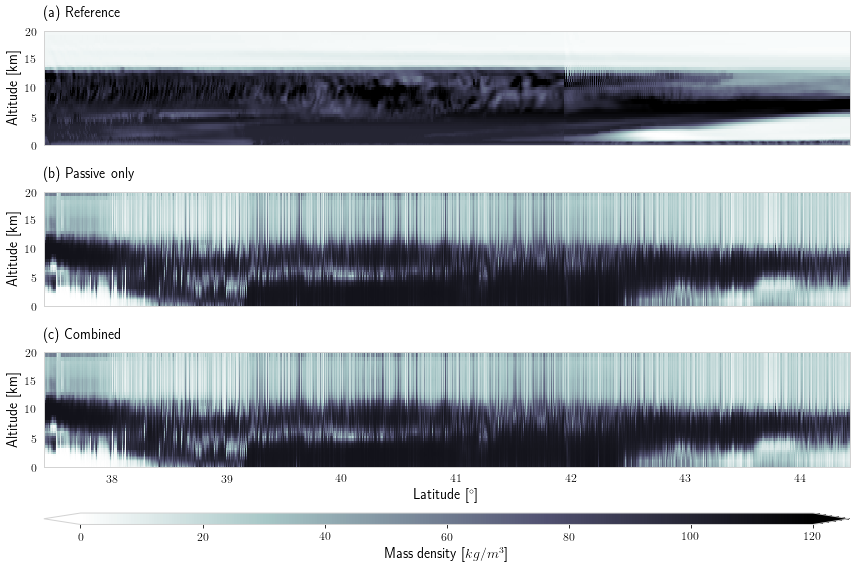

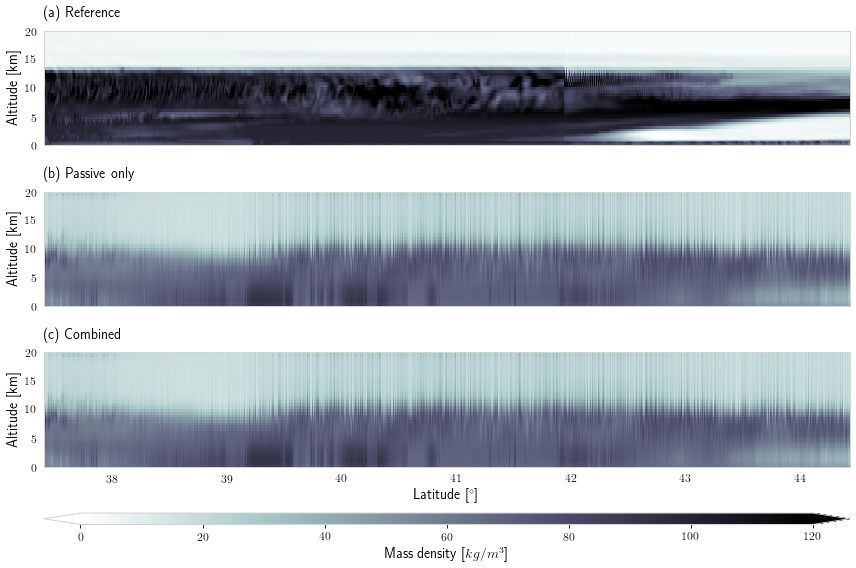

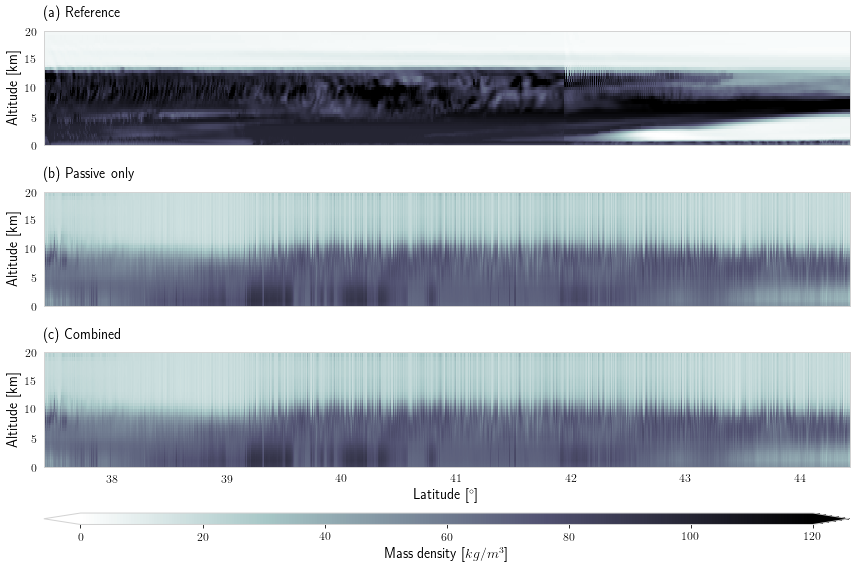

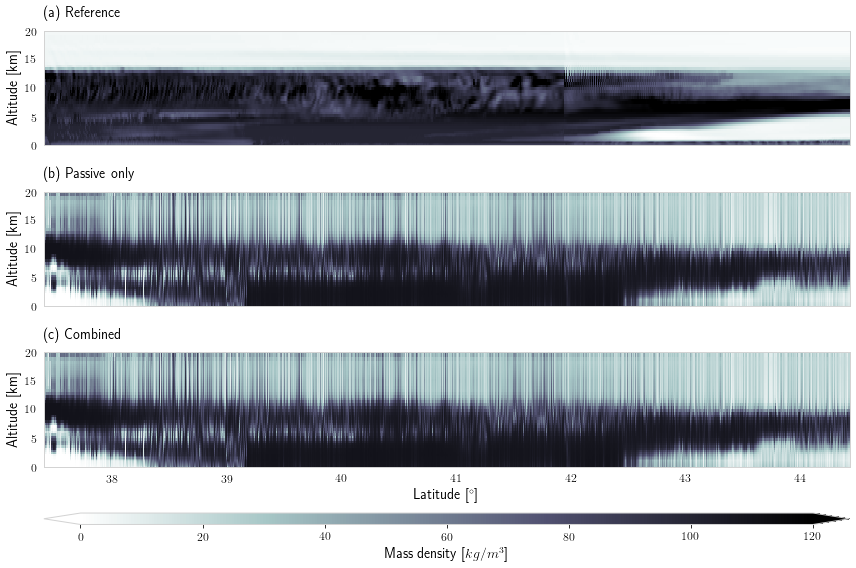

In [16]:
from matplotlib.colors import LogNorm, Normalize
from matplotlib.cm import bone_r
from typhon.physics.atmosphere import vmr2relative_humidity
lats = reference["lat"]
z    = reference["z"]
name = "Mass density [$kg/m^3$]"
norm = Normalize(0, 120)
cmap = bone_r
titles = ["Reference", "Passive only", "Combined"]

for h in [h for h in results.keys() if "None" in h]:
    print(h)
    rs    = results[h]
    rs_po = results[h]
    rs_ro = results[h]
    
    qs = []
    qs += [reference["h2o"] * 100]
    qs += [rs_po["H2O"] * 100]
    #qs += vmr2relative_humidity(rs["H2O"], p, t, e_eq = p_eq)
    qs += [rs["H2O"] * 100]
    print(qs[-1].max())
    
    f = plt.figure(figsize = (12, 8))
    plot_results(lats, z, qs, name, norm, cmap = cmap, titles = titles)
    if "None" in h:
        f.savefig("../../../plots/results_rh_b_" + h[:-5] + ".png", bbox_inches = "tight", dpi = 300)
    else:
        f.savefig("../../../plots/results_rh_b_" + h + ".png", bbox_inches = "tight", dpi = 300)

## Liquid cloud

GemCloudIce_None


/home/simonpf/build/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Log scale: values of z <= 0 have been masked


0.0008373349
IceSphere_None
0.0008606086
LargePlateAggregate_None
0.00036226347
LargeColumnAggregate_None
0.0003688918
PlateType1_None
0.0008327422
SectorSnowflake_None
0.0005990194
8-ColumnAggregate_None
0.00035011224
GemSnow_None
0.00088046957


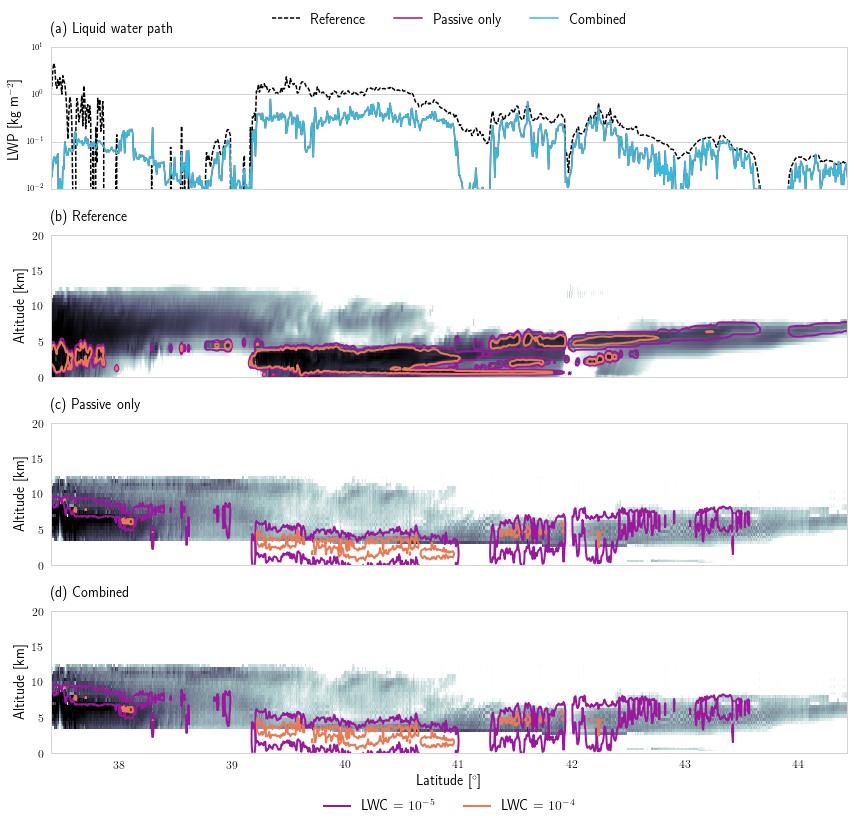

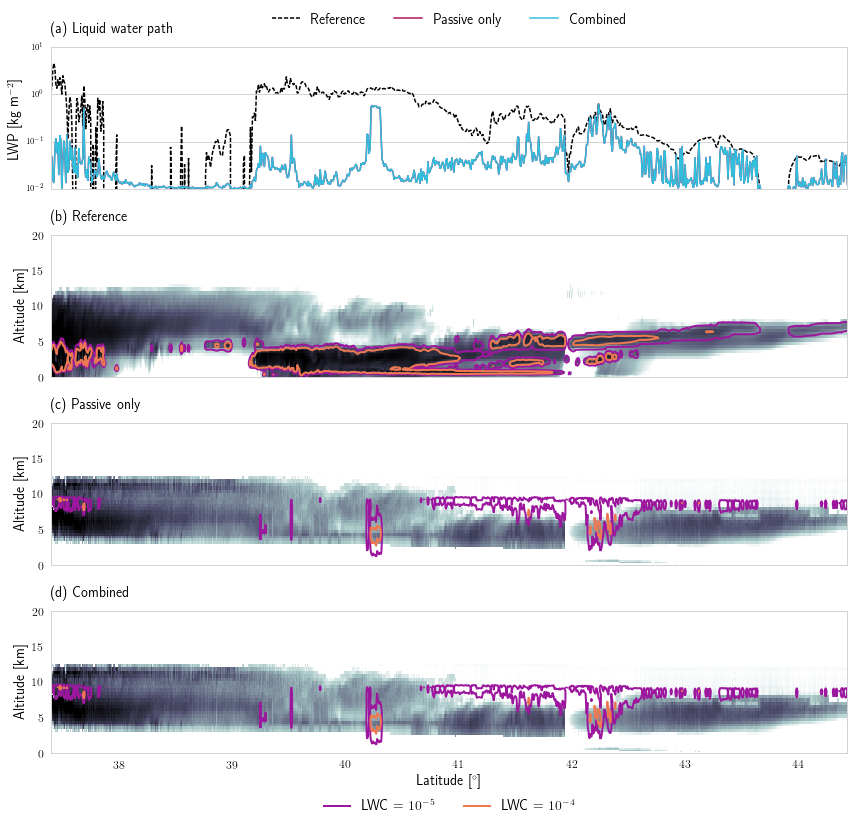

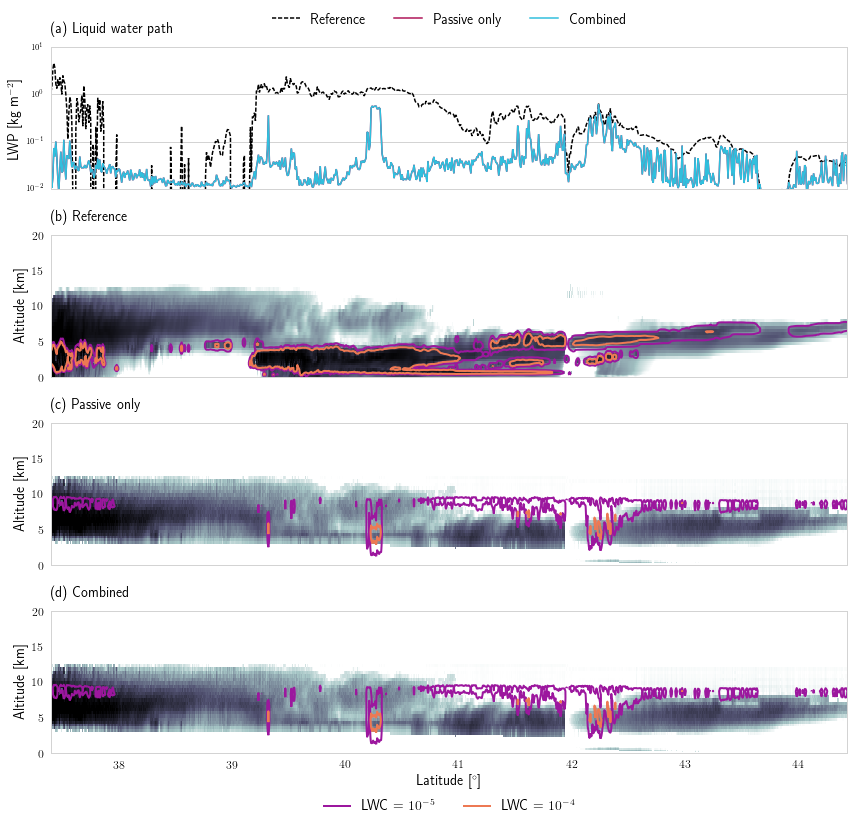

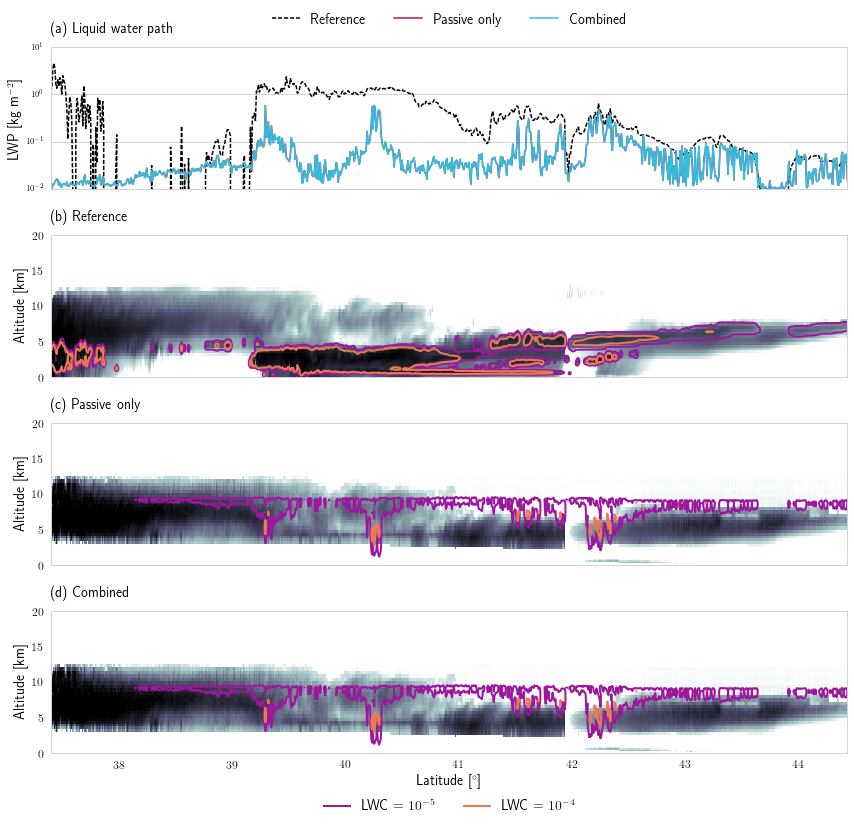

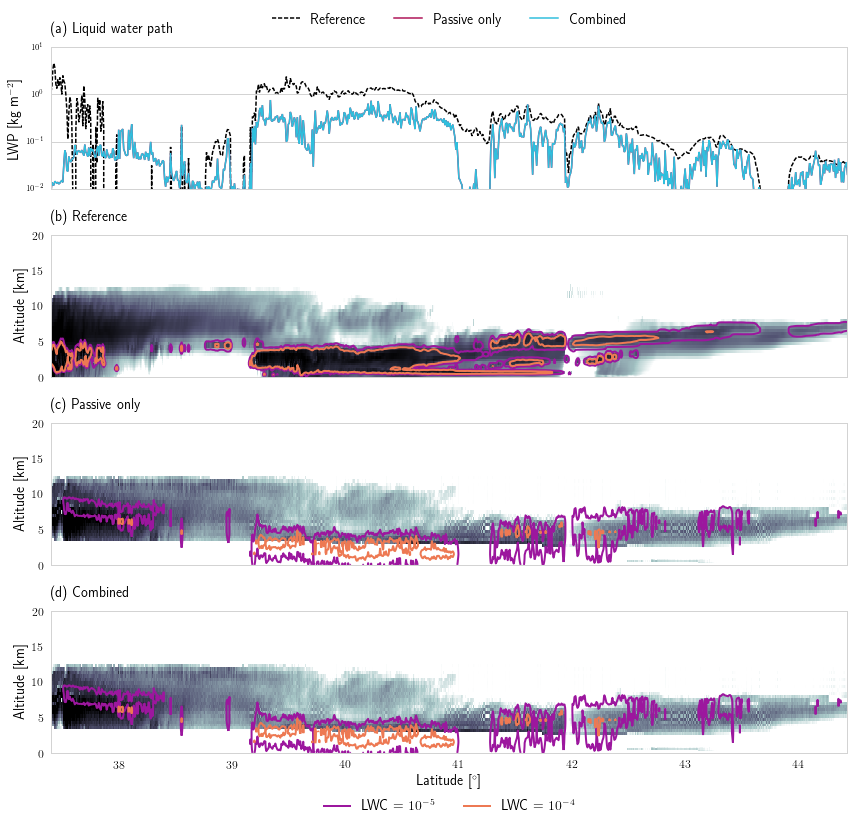

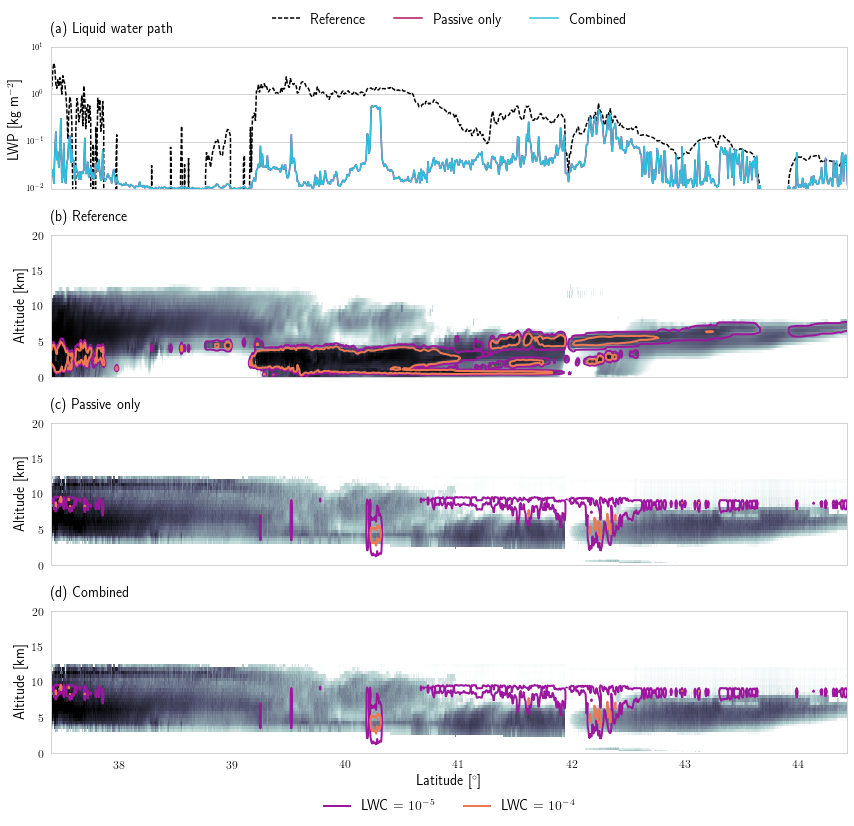

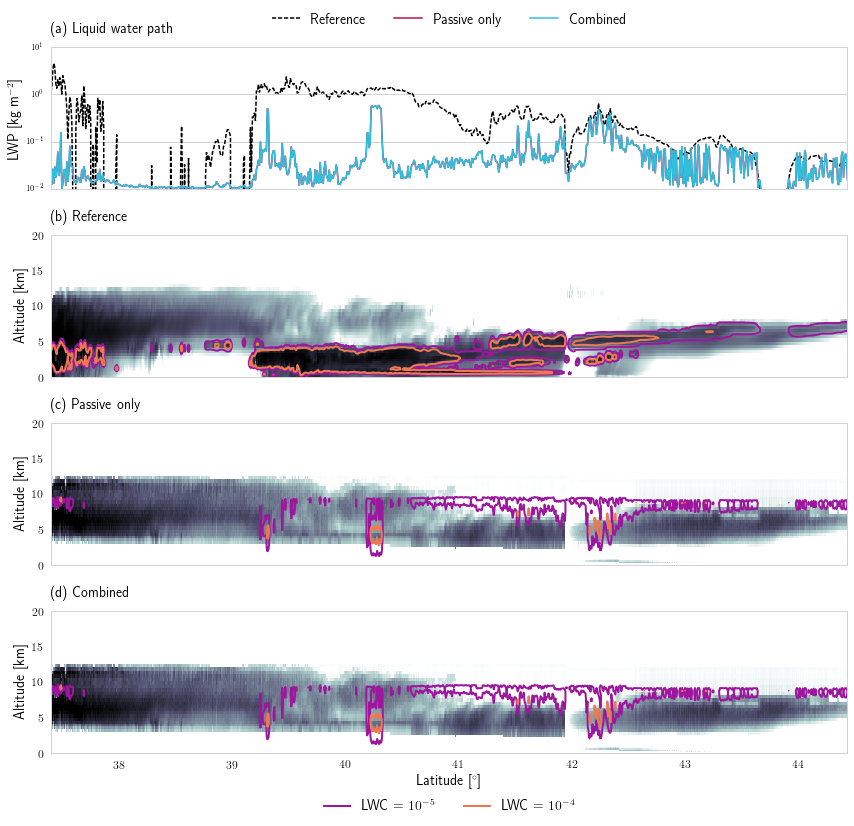

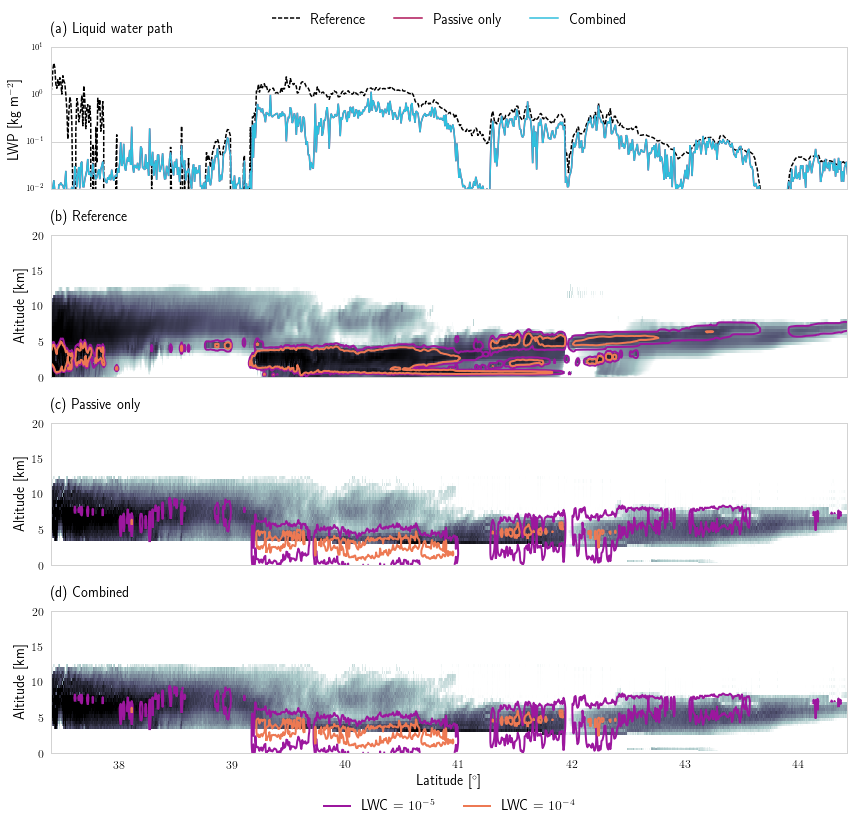

In [15]:
from matplotlib import patches
from matplotlib.colors import LogNorm
from matplotlib.cm import bone_r, Greys
from scipy.ndimage.filters import gaussian_filter
lats = reference["lat"]
z    = reference["z"]
name = "Mass density [kg m$^{-3}$]"
norm = LogNorm(1e-6, 1e-3)
cmap = bone_r
titles = ["Reference", "Passive only", "Combined", ""]

for h in [h for h in results.keys() if "None" in h]:
    print(h)
    rs    = results[h]
    rs_po = results[h]
    rs_ro = results[h]
    
    # Column  totals
    lwp_r  = np.trapz(reference["lwc"], x = z)
    lwp_po = np.trapz(rs_po["cloud_water"], x = z)
    lwp    = np.trapz(rs["cloud_water"], x = z)
    
    hmc = sum([reference[k] for k in ["iwc", "swc", "gwc", "hwc", "lwc", "rwc"]])
    hmc = np.maximum(hmc, 1e-8)
    qs = []
    qs += [hmc]
    qs += [iwc(rs_po["ice_n0"], rs_po["ice_dm"])]
    qs += [iwc(rs["ice_n0"], rs["ice_dm"])]
    
    f = plt.figure(figsize = (12, 12))
    plot_results(lats, z, qs, name, norm, [lwp_r, lwp_po, lwp], cmap, None, None, titles)
    
    ax = f.axes[0]
    ax.set_title("(a) Liquid water path", loc = "left", fontsize = 14)
    ax.set_ylabel("LWP [kg m$^{-2}$]")
    ax.set_ylim([1e-2, 1e1])
    
    handles = []
    handles += [plt.Line2D((0,1),(0,0), color='k', ls = "--")]
    handles += [plt.Line2D((0,1),(0,0), color='C0')]
    handles += [plt.Line2D((0,1),(0,0), color='C2')]
    labels = ["Reference", "Passive only", "Combined"]
    ax.legend(handles = handles, labels = labels, loc = "center", bbox_to_anchor = [0.5, 1.2],
             ncol = 3, fontsize = 14)
   
    x = reference["lat"]
    y = reference["z"] / 1e3
    
    ax = f.axes[0]
    lines = ax.get_children()[:3]
    lines[0].set_color("k")
    lines[0].set_linestyle("--")
    lines[1].set_color("C0")
    lines[2].set_color("C2")
    
    ax = f.axes[1]
    q = gaussian_filter(reference["lwc"], 0.5)
    ax.contour(x, y, q.T, [1e-5, 1e-4], cmap = "plasma", norm = LogNorm(1e-6, 1e-3), linewidths = [2])
    ax.set_yticks([0, 5, 10, 15, 20])
    
    ax = f.axes[2]
    q = rs_po["cloud_water"]
    ax.contour(x, y, q.T, [1e-5, 1e-4], cmap = "plasma", norm = LogNorm(1e-6, 1e-3), linewidths = [2])
    ax.set_yticks([0, 5, 10, 15, 20])
    
    ax = f.axes[3]
    q = rs["cloud_water"]
    print(q.max())
    cs = ax.contour(x, y, q.T, [1e-5, 1e-4], cmap = "plasma", norm = LogNorm(1e-6, 1e-3), linewidths = [2])
    ax.set_yticks([0, 5, 10, 15, 20])
    
    ax = f.axes[4]
    ax.clear()
    
    lcs   = cs.collections
    names = ["LWC = $10^{-5}$", "LWC = $10^{-4}$"]
    ax.set_axis_off()
    ax.legend(handles = lcs, labels = names,
              ncol = 2,
              loc = "center",
              fontsize = 14)
    
    
    if "None" in h:
        f.savefig("../../../plots/results_cw_b_" + h[:-5] + ".png", bbox_inches = "tight", dpi = 300)
    else:
        f.savefig("../../../plots/results_cw_b_" + h + ".png", bbox_inches = "tight", dpi = 300)

In [ ]:
p
